![](https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png)

# House Prices Prediction

In [163]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import plot_model


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



# from tensorflow.keras.layers.Layer import Sequential, Dense, ReLU
# Попросите покупателя дома описать дом своей мечты, 
# и он, вероятно, не начнет с высоты потолка подвала 
# или близости к железной дороге с востока на запад. 
# Но набор данных этого конкурса игровых площадок доказывает, 
# что гораздо больше влияет на ценовые переговоры, 
# чем количество спален или забор из белого штакетника.

# С 79 независимыми переменными, описывающими (почти) каждый аспект жилых домов в Эймсе, 
# штат Айова, этот конкурс ставит перед вами задачу предсказать окончательную цену каждого дома.

# Читаем и изучаем полученные данные

**Читаем данные и обрезаем Id столбец, он не нужен для обучения** 

In [2]:
data_train = pd.read_csv(r'train.csv')
data_train = data_train.drop('Id', axis=1)

**Выводим первые пять строк**

In [3]:
data_train.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

**Необходимо произвести поиск и заполнение отсутствующих значений**

Я использовал функцию участника соревнования Kaggle https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

In [4]:
def ProcentOfMissingValue(data_train):
    missing = (round(data_train.isnull().mean()*100,10)) 
    missing = missing[missing>0].sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    missing.plot.bar()
    # plt.axis("Percent of missing values")
    plt.ylabel("Percent of missing values")
    plt.xlabel("Features")
    plt.show()
    print('Процент пропущенных значений в столбцах')
    print(missing)
    print('------------------------------------------------')
    for i in missing.index:
        print(i, data_train[i].dtype)
    
# ProcentOfMissingValue(data_train)

**Проверяем типы данных в которых отсутствую значения**

In [5]:
# for i in missing.index:
#     print(i, data_train[i].dtype)

Теоретически, можно вычислить значения которые пропущены и восстановить их. Изучим на основе цены и значений какими могут быть пропущенные значения.

1.PoolQC - качество бассейна

In [6]:
data_train['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

Мы видим, что имеется 3 класса Хорошо, прекрасно и средне. Но также имеется еще одна графа PoolArea, отображающая площадь бассейна, соответственно если данное значение равно нулю, то можно вместо значения в графе PollQC NaN заменить на None.

In [7]:
data_train['PoolArea'].value_counts()

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: PoolArea, dtype: int64

In [8]:
data_train['PoolQC'] = data_train['PoolQC'].fillna(value = 'None')

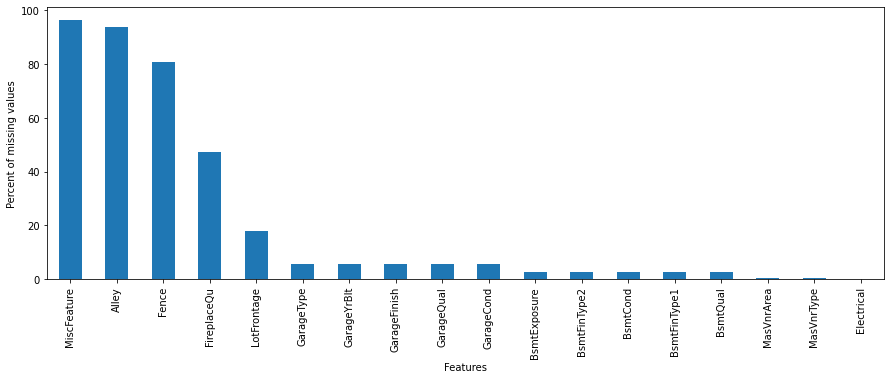

Процент пропущенных значений в столбцах
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
MiscFeature object
Alley object
Fence object
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtCond object
BsmtFinType1 object
BsmtQual object
MasVnrArea float64
MasVnrType object
Electrical object


In [9]:
ProcentOfMissingValue(data_train)

Как видно, одно значение было заменено

2. MiscFeature

In [10]:
data_train['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

Shed - сарай

Gar2 - Второй гараж


Построим диаграмму рассеивания класса и цены.

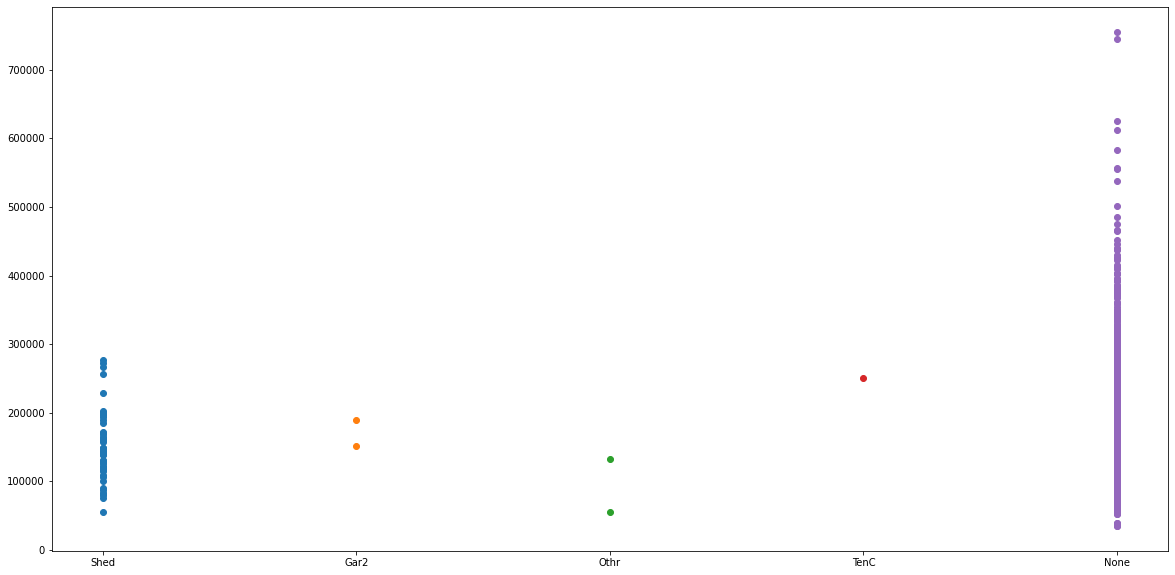

In [11]:
plt.figure(figsize=(20,10))
plt.scatter(data_train[data_train['MiscFeature'] == 'Shed']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Shed']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'Gar2']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Gar2']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'Othr']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Othr']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'TenC']['MiscFeature'],data_train[data_train['MiscFeature'] == 'TenC']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'].isna() == True]['MiscFeature'].fillna(value = 'None'), data_train[data_train['MiscFeature'].isna() == True]['SalePrice'])
plt.show()

Мы можем предположить, что у других домов отсутствуют дополнительные значения.

In [12]:
data_train['MiscFeature'] = data_train['MiscFeature'].fillna(value = 'None')

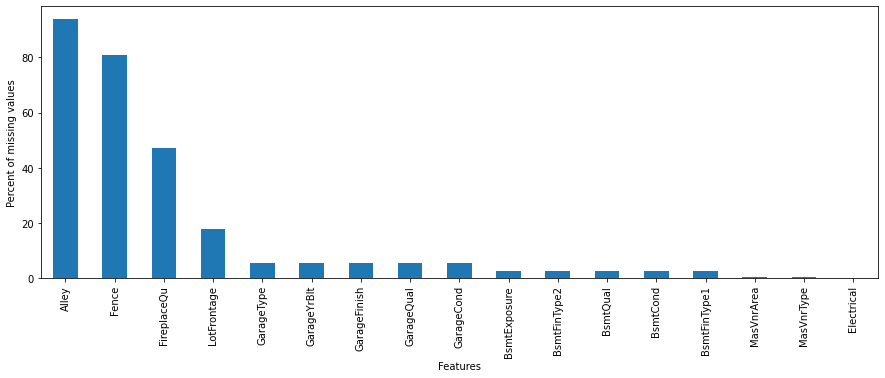

Процент пропущенных значений в столбцах
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
Alley object
Fence object
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrArea float64
MasVnrType object
Electrical object


In [13]:
ProcentOfMissingValue(data_train)

3. Alley Тип доступа к аллее

In [14]:
data_train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

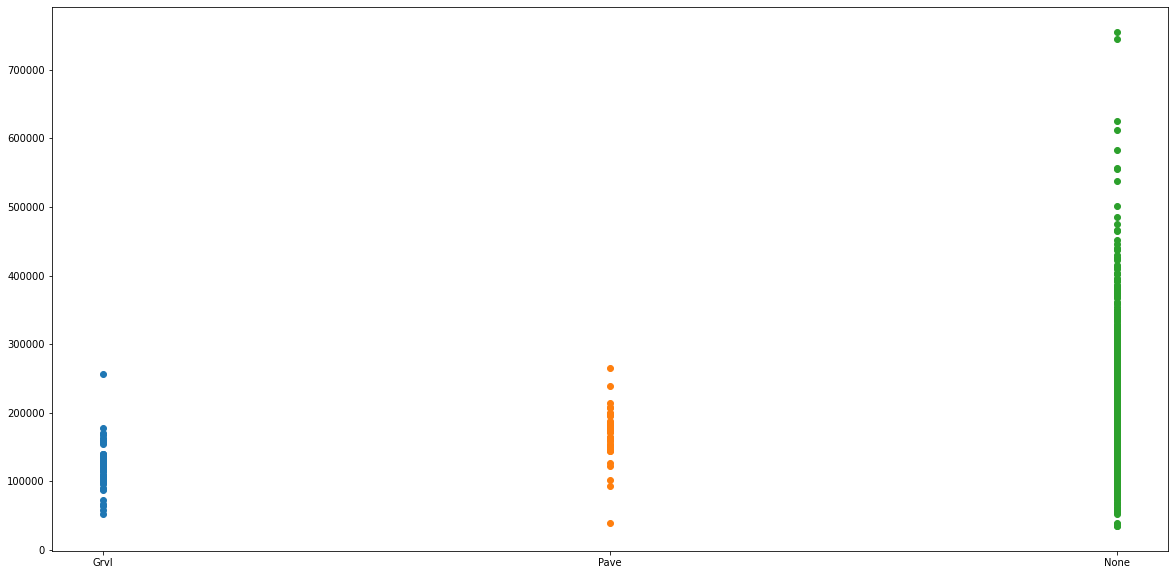

In [15]:
plt.figure(figsize=(20,10))
plt.scatter(data_train[data_train['Alley'] == 'Grvl']['Alley'],data_train[data_train['Alley'] == 'Grvl']['SalePrice'])
plt.scatter(data_train[data_train['Alley'] == 'Pave']['Alley'],data_train[data_train['Alley'] == 'Pave']['SalePrice'])
plt.scatter(data_train[data_train['Alley'].isna() == True]['Alley'].fillna(value = 'None'), data_train[data_train['Alley'].isna() == True]['SalePrice'])
plt.show()

Как можно увидеть, отсутствующий тип жилья располагается как в зоне Pave так и в зоне Grvl, таким образом мы также можем заменить данные пропущенные значения на None

In [16]:
data_train['Alley'] = data_train['Alley'].fillna(value = 'None')

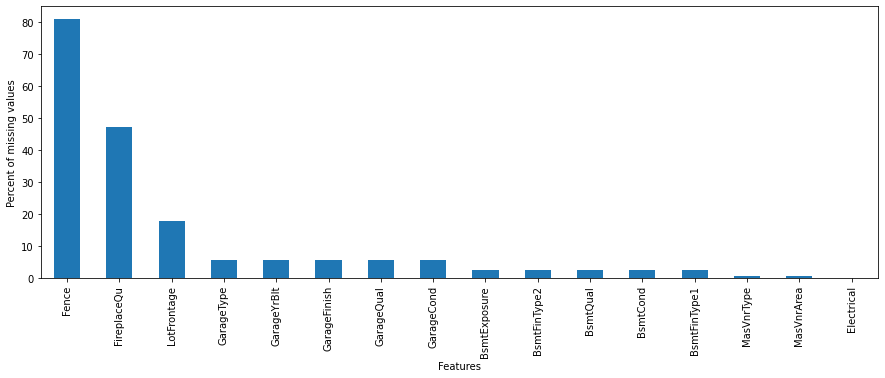

Процент пропущенных значений в столбцах
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
Fence object
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [17]:
ProcentOfMissingValue(data_train)

4. Fence Качество забора

In [18]:
data_train['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Мы не можем определить по имеющимся метрикам качество изгороди и ее существование, соответственно заменяем значения на None

In [19]:
data_train["Fence"] = data_train["Fence"].fillna("None")

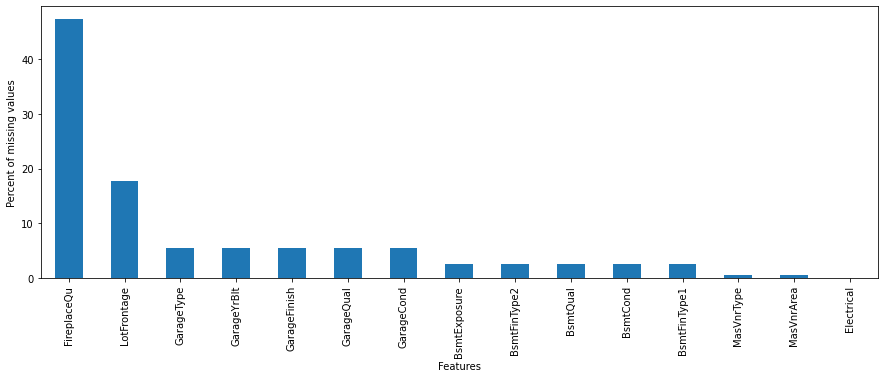

Процент пропущенных значений в столбцах
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [20]:
ProcentOfMissingValue(data_train)

5. FireplaceQu Качество камина

In [21]:
data_train[['FireplaceQu','Fireplaces']]

FireplaceQu  Fireplaces
0            NaN           0
1             TA           1
2             TA           1
3             Gd           1
4             TA           1
...          ...         ...
1455          TA           1
1456          TA           2
1457          Gd           2
1458         NaN           0
1459         NaN           0

[1460 rows x 2 columns]

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Как можно понять из описания к данной переменной, если отсутствуют значения качества, то отсутствует камин, соответственном мы можем заменить на None

In [22]:
data_train["FireplaceQu"] = data_train["FireplaceQu"].fillna("None")

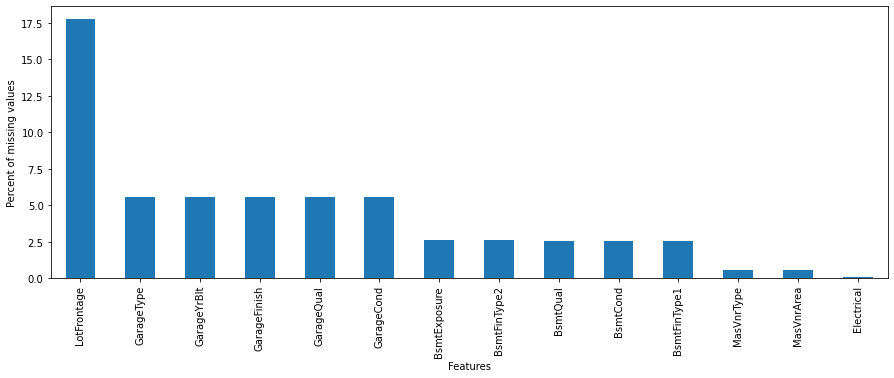

Процент пропущенных значений в столбцах
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [23]:
ProcentOfMissingValue(data_train)

6. LotFrontage Линейные футы улицы, соединенной с недвижимостью

In [24]:
data_train['LotFrontage'].isna().sum()

259

Данная переменная имеет 259 пропущенных значений

In [25]:
data_train['LotFrontage'].head(100)

0     65.0
1     80.0
2     68.0
3     60.0
4     84.0
      ... 
95     NaN
96    78.0
97    73.0
98    85.0
99    77.0
Name: LotFrontage, Length: 100, dtype: float64

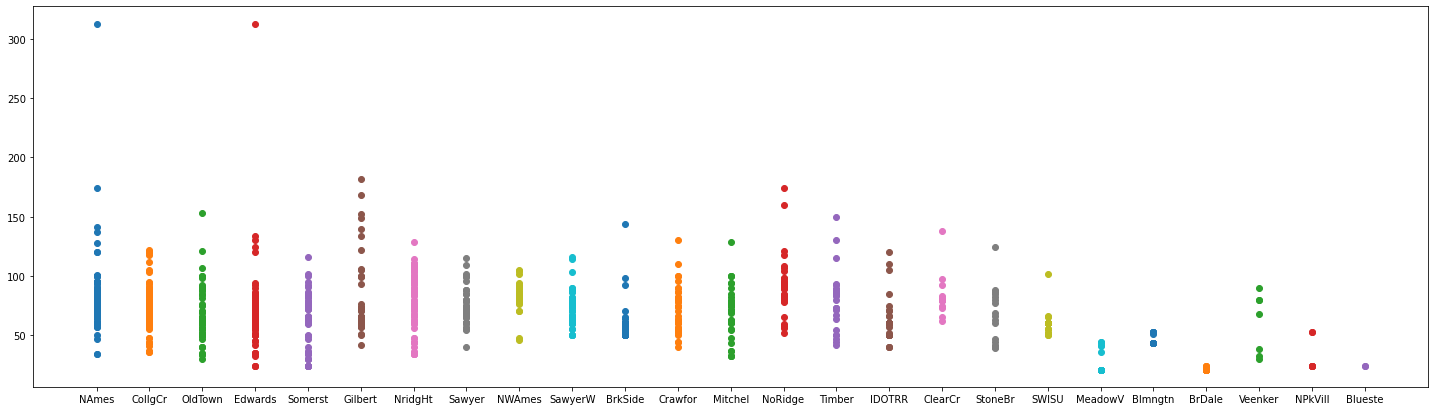

In [26]:
plt.figure(figsize=(25,7))
for i in data_train['Neighborhood'].value_counts().index:
    plt.scatter(data_train[data_train['Neighborhood'] == i]['Neighborhood'],data_train[data_train['Neighborhood'] == i]['LotFrontage'])
plt.show()
# plt.scatter(data_train[data_train['Neighborhood'] == 'NAmes']['Neighborhood'],data_train[data_train['Neighborhood'] == 'NAmes']['LotFrontage'])

Заполним средними значениями пропущенные значения в поле LotFrontage

In [27]:
data_train['Neighborhood'].value_counts().index

Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'Gilbert',
       'NridgHt', 'Sawyer', 'NWAmes', 'SawyerW', 'BrkSide', 'Crawfor',
       'Mitchel', 'NoRidge', 'Timber', 'IDOTRR', 'ClearCr', 'StoneBr', 'SWISU',
       'MeadowV', 'Blmngtn', 'BrDale', 'Veenker', 'NPkVill', 'Blueste'],
      dtype='object')

In [28]:
data_train['LotFrontage'].isna().sum()

259

In [29]:
for i in data_train['Neighborhood'].value_counts().index:
    data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data_train['Neighborhood'] == i]['LotFrontage'].median()

C:\Users\Nikita\AppData\Local\Temp\ipykernel_2320\46621965.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data_train['Neighborhood'] == i]['LotFrontage'].median()
C:\Users\Nikita\AppData\Local\Temp\ipykernel_2320\46621965.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data_train['Neighborhood'] == i]['LotFrontage'].median()
C:\Users\Nikita\AppData\Local\Temp\ipykernel_2320\46621965.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data

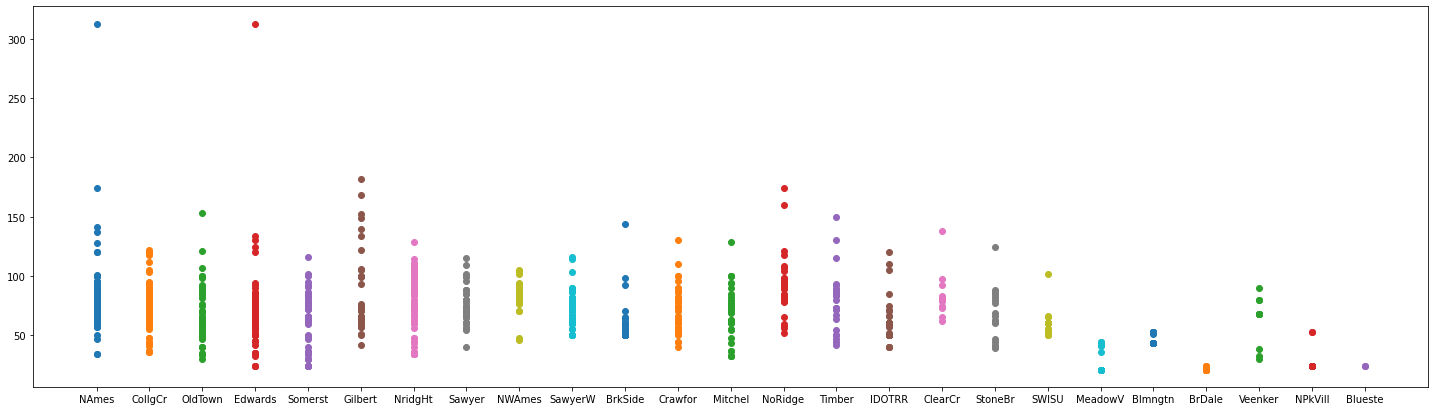

0

In [30]:
plt.figure(figsize=(25,7))
for i in data_train['Neighborhood'].value_counts().index:
    plt.scatter(data_train[data_train['Neighborhood'] == i]['Neighborhood'],data_train[data_train['Neighborhood'] == i]['LotFrontage'])
plt.show()
data_train['LotFrontage'].isna().sum()

In [31]:
data_train['LotFrontage'].head(100)

0     65.0
1     80.0
2     68.0
3     60.0
4     84.0
      ... 
95    65.0
96    78.0
97    73.0
98    85.0
99    77.0
Name: LotFrontage, Length: 100, dtype: float64

Как можно наблюдать, пропущенные данные заполнены

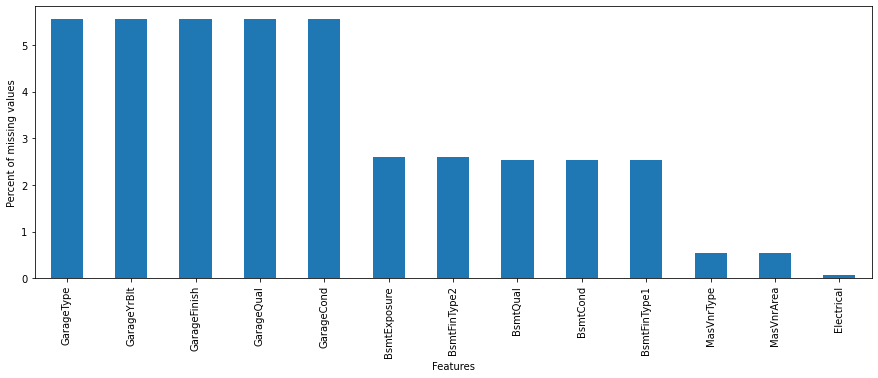

Процент пропущенных значений в столбцах
GarageType      5.547945
GarageYrBlt     5.547945
GarageFinish    5.547945
GarageQual      5.547945
GarageCond      5.547945
BsmtExposure    2.602740
BsmtFinType2    2.602740
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrType      0.547945
MasVnrArea      0.547945
Electrical      0.068493
dtype: float64
------------------------------------------------
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [32]:
ProcentOfMissingValue(data_train)

In [33]:
# test.loc[test['Neighborhood'] == 'NAmes'][test['LotFrontage'].isna() == True].index

In [34]:
# test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].median()

In [35]:
# test.loc[test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].index, 'LotFrontage'] = test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].median()

In [36]:
# test[data_train['Neighborhood'] == 'NAmes']['LotFrontage']

In [37]:
# test.loc[test[data_train['Neighborhood'] == 'BrDale']['LotFrontage'].index, 'LotFrontage']

In [38]:
# data_train.loc[test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].index, 'LotFrontage']

In [39]:
# test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].index

In [40]:
# data_train[data_train['Neighborhood'] == 'NAmes'][data_train['LotFrontage'].isna() == True]['LotFrontage'].index

7.  GarageType      Место в гараже

    GarageYrBlt     Год постройки гаража.

    GarageFinish    Внутренняя отделка гаража

    GarageQual      качество гаража

    GarageCond      Состояние гаража

In [41]:
# data_train[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']].isna().

Для анализа можно использовать еще две переменных

    GarageCars: Размер гаража по вместимости автомобиля

    GarageArea: Размер гаража в квадратных футах.

In [42]:
data_train.loc[data_train[data_train['GarageCond'].isna() == True].index][['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','GarageCars','GarageArea']]

GarageType  GarageYrBlt GarageFinish GarageQual GarageCond  GarageCars  \
39          NaN          NaN          NaN        NaN        NaN           0   
48          NaN          NaN          NaN        NaN        NaN           0   
78          NaN          NaN          NaN        NaN        NaN           0   
88          NaN          NaN          NaN        NaN        NaN           0   
89          NaN          NaN          NaN        NaN        NaN           0   
...         ...          ...          ...        ...        ...         ...   
1349        NaN          NaN          NaN        NaN        NaN           0   
1407        NaN          NaN          NaN        NaN        NaN           0   
1449        NaN          NaN          NaN        NaN        NaN           0   
1450        NaN          NaN          NaN        NaN        NaN           0   
1453        NaN          NaN          NaN        NaN        NaN           0   

      GarageArea  
39             0  
48             0  
78             0  
88             0  
89             0  
...          ...  
1349           0  
1407           0  
1449           0  
1450           0  
1453           0  

[81 rows x 7 columns]

In [43]:
# for i in data_train.loc[data_train[data_train['GarageType'].isna() == True].index]['GarageArea']:
#     print(i)

Можно увидеть, что переменная GarageArea == 0 тогда другие значения == NaN

In [44]:
data_train['GarageType'].dtype

dtype('O')

In [45]:
data_train['GarageType'] = data_train['GarageType'].fillna('None')

In [46]:
data_train['GarageYrBlt'] = data_train['GarageYrBlt'].fillna(0)

In [47]:
data_train['GarageFinish'] = data_train['GarageFinish'].fillna('None')

In [48]:
data_train['GarageQual'] = data_train['GarageQual'].fillna('None')

In [49]:
data_train['GarageCond'] = data_train['GarageCond'].fillna('None')

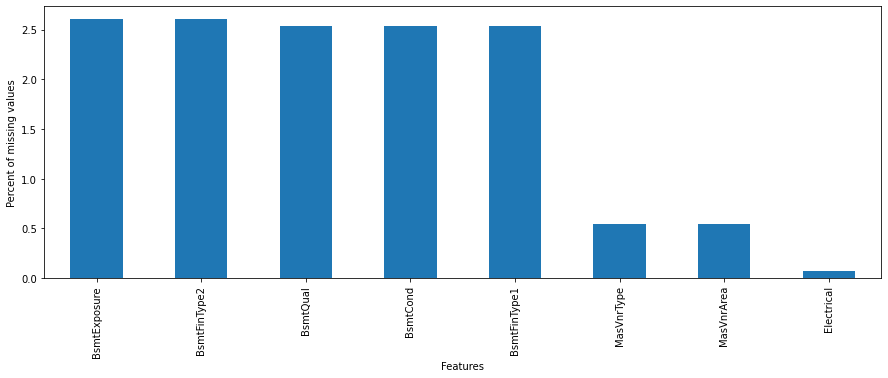

Процент пропущенных значений в столбцах
BsmtExposure    2.602740
BsmtFinType2    2.602740
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrType      0.547945
MasVnrArea      0.547945
Electrical      0.068493
dtype: float64
------------------------------------------------
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [50]:
ProcentOfMissingValue(data_train)

    8.BsmtExposure Стены подвала на уровне выхода или сада.
    BsmtFinType2   Качество второй обработанной области (если присутствует)

Все значения имеющие связи с подвалом:

    BsmtQual: Высота подвала
    
    
    BsmtCond: Общее состояние подвала
    
    
    TotalBsmtSF: Общая площадь подвала в квадратных футах.
    
    
    BsmtFullBath: Ванные комнаты в подвале
    
    
    BsmtHalfBath: Половина ванных комнат в подвале
    
    

Выведим пропущенные значения и значения которые имеют связь с пропущенными значениями

In [51]:
data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

BsmtExposure BsmtFinType2 BsmtQual BsmtCond  TotalBsmtSF  BsmtFullBath  \
17            NaN          NaN      NaN      NaN            0             0   
39            NaN          NaN      NaN      NaN            0             0   
90            NaN          NaN      NaN      NaN            0             0   
102           NaN          NaN      NaN      NaN            0             0   
156           NaN          NaN      NaN      NaN            0             0   
182           NaN          NaN      NaN      NaN            0             0   
259           NaN          NaN      NaN      NaN            0             0   
342           NaN          NaN      NaN      NaN            0             0   
362           NaN          NaN      NaN      NaN            0             0   
371           NaN          NaN      NaN      NaN            0             0   
392           NaN          NaN      NaN      NaN            0             0   
520           NaN          NaN      NaN      NaN            0             0   
532           NaN          NaN      NaN      NaN            0             0   
533           NaN          NaN      NaN      NaN            0             0   
553           NaN          NaN      NaN      NaN            0             0   
646           NaN          NaN      NaN      NaN            0             0   
705           NaN          NaN      NaN      NaN            0             0   
736           NaN          NaN      NaN      NaN            0             0   
749           NaN          NaN      NaN      NaN            0             0   
778           NaN          NaN      NaN      NaN            0             0   
868           NaN          NaN      NaN      NaN            0             0   
894           NaN          NaN      NaN      NaN            0             0   
897           NaN          NaN      NaN      NaN            0             0   
948           NaN          Unf       Gd       TA          936             0   
984           NaN          NaN      NaN      NaN            0             0   
1000          NaN          NaN      NaN      NaN            0             0   
1011          NaN          NaN      NaN      NaN            0             0   
1035          NaN          NaN      NaN      NaN            0             0   
1045          NaN          NaN      NaN      NaN            0             0   
1048          NaN          NaN      NaN      NaN            0             0   
1049          NaN          NaN      NaN      NaN            0             0   
1090          NaN          NaN      NaN      NaN            0             0   
1179          NaN          NaN      NaN      NaN            0             0   
1216          NaN          NaN      NaN      NaN            0             0   
1218          NaN          NaN      NaN      NaN            0             0   
1232          NaN          NaN      NaN      NaN            0             0   
1321          NaN          NaN      NaN      NaN            0             0   
1412          NaN          NaN      NaN      NaN            0             0   

      BsmtHalfBath  
17               0  
39               0  
90               0  
102              0  
156              0  
182              0  
259              0  
342              0  
362              0  
371              0  
392              0  
520              0  
532              0  
533              0  
553              0  
646              0  
705              0  
736              0  
749              0  
778              0  
868              0  
894              0  
897              0  
948              0  
984              0  
1000             0  
1011             0  
1035             0  
1045             0  
1048             0  
1049             0  
1090             0  
1179             0  
1216             0  
1218             0  
1232             0  
1321             0  
1412             0

Как можно видеть, практически все значения можно заполнить значениями None в связи с отсутствием подвального помещения, кроме индекса 948

Значения под индексом 948 можно заполнить изучив значения столбцов

In [52]:
data_train[(data_train['BsmtFinType2'] == 'Unf') & (data_train['BsmtQual'] == 'Gd') & (data_train['BsmtCond'] == 'TA') & (data_train['TotalBsmtSF'] > 900) & (data_train['TotalBsmtSF'] < 1000)][['BsmtExposure']].value_counts()


BsmtExposure
No              49
Mn               6
Gd               5
Av               3
dtype: int64

Были настроены фильтры по значениям (data_train['BsmtFinType2'] == 'Unf') & (data_train['BsmtQual'] == 'Gd') & (data_train['BsmtCond'] == 'TA') & (data_train['TotalBsmtSF'] > 900) & (data_train['TotalBsmtSF'] < 1000), и мы получили что наибольшая вероятность попадания значения с этими характеристиками в значение 'No'

In [53]:
data_train.loc[948,'BsmtExposure'] = 'No'

Еще раз провряем значения 

In [54]:
data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

BsmtExposure BsmtFinType2 BsmtQual BsmtCond  TotalBsmtSF  BsmtFullBath  \
17            NaN          NaN      NaN      NaN            0             0   
39            NaN          NaN      NaN      NaN            0             0   
90            NaN          NaN      NaN      NaN            0             0   
102           NaN          NaN      NaN      NaN            0             0   
156           NaN          NaN      NaN      NaN            0             0   
182           NaN          NaN      NaN      NaN            0             0   
259           NaN          NaN      NaN      NaN            0             0   
342           NaN          NaN      NaN      NaN            0             0   
362           NaN          NaN      NaN      NaN            0             0   
371           NaN          NaN      NaN      NaN            0             0   
392           NaN          NaN      NaN      NaN            0             0   
520           NaN          NaN      NaN      NaN            0             0   
532           NaN          NaN      NaN      NaN            0             0   
533           NaN          NaN      NaN      NaN            0             0   
553           NaN          NaN      NaN      NaN            0             0   
646           NaN          NaN      NaN      NaN            0             0   
705           NaN          NaN      NaN      NaN            0             0   
736           NaN          NaN      NaN      NaN            0             0   
749           NaN          NaN      NaN      NaN            0             0   
778           NaN          NaN      NaN      NaN            0             0   
868           NaN          NaN      NaN      NaN            0             0   
894           NaN          NaN      NaN      NaN            0             0   
897           NaN          NaN      NaN      NaN            0             0   
984           NaN          NaN      NaN      NaN            0             0   
1000          NaN          NaN      NaN      NaN            0             0   
1011          NaN          NaN      NaN      NaN            0             0   
1035          NaN          NaN      NaN      NaN            0             0   
1045          NaN          NaN      NaN      NaN            0             0   
1048          NaN          NaN      NaN      NaN            0             0   
1049          NaN          NaN      NaN      NaN            0             0   
1090          NaN          NaN      NaN      NaN            0             0   
1179          NaN          NaN      NaN      NaN            0             0   
1216          NaN          NaN      NaN      NaN            0             0   
1218          NaN          NaN      NaN      NaN            0             0   
1232          NaN          NaN      NaN      NaN            0             0   
1321          NaN          NaN      NaN      NaN            0             0   
1412          NaN          NaN      NaN      NaN            0             0   

      BsmtHalfBath  
17               0  
39               0  
90               0  
102              0  
156              0  
182              0  
259              0  
342              0  
362              0  
371              0  
392              0  
520              0  
532              0  
533              0  
553              0  
646              0  
705              0  
736              0  
749              0  
778              0  
868              0  
894              0  
897              0  
984              0  
1000             0  
1011             0  
1035             0  
1045             0  
1048             0  
1049             0  
1090             0  
1179             0  
1216             0  
1218             0  
1232             0  
1321             0  
1412             0

Как можно видеть, значение под индексом 948 пропало

Остальыне значения можно заполнить None

In [55]:
index_ = data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2']].index
rows_ = ['BsmtExposure', 'BsmtFinType2']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [56]:
data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2']]

Empty DataFrame
Columns: [BsmtExposure, BsmtFinType2]
Index: []

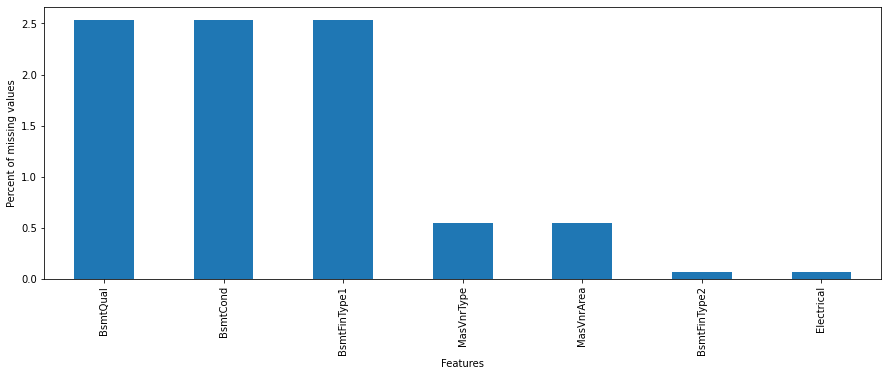

Процент пропущенных значений в столбцах
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrType      0.547945
MasVnrArea      0.547945
BsmtFinType2    0.068493
Electrical      0.068493
dtype: float64
------------------------------------------------
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
BsmtFinType2 object
Electrical object


In [57]:
ProcentOfMissingValue(data_train)

    9. BsmtQual Высота подвала
    
       BsmtCond Общее состояние подвала
    
       BsmtFinType1 Качество отделки цокольного этажа

In [58]:
data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond', 'BsmtFinType1','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

BsmtExposure BsmtFinType2 BsmtQual BsmtCond BsmtFinType1  TotalBsmtSF  \
17           None         None      NaN      NaN          NaN            0   
39           None         None      NaN      NaN          NaN            0   
90           None         None      NaN      NaN          NaN            0   
102          None         None      NaN      NaN          NaN            0   
156          None         None      NaN      NaN          NaN            0   
182          None         None      NaN      NaN          NaN            0   
259          None         None      NaN      NaN          NaN            0   
342          None         None      NaN      NaN          NaN            0   
362          None         None      NaN      NaN          NaN            0   
371          None         None      NaN      NaN          NaN            0   
392          None         None      NaN      NaN          NaN            0   
520          None         None      NaN      NaN          NaN            0   
532          None         None      NaN      NaN          NaN            0   
533          None         None      NaN      NaN          NaN            0   
553          None         None      NaN      NaN          NaN            0   
646          None         None      NaN      NaN          NaN            0   
705          None         None      NaN      NaN          NaN            0   
736          None         None      NaN      NaN          NaN            0   
749          None         None      NaN      NaN          NaN            0   
778          None         None      NaN      NaN          NaN            0   
868          None         None      NaN      NaN          NaN            0   
894          None         None      NaN      NaN          NaN            0   
897          None         None      NaN      NaN          NaN            0   
984          None         None      NaN      NaN          NaN            0   
1000         None         None      NaN      NaN          NaN            0   
1011         None         None      NaN      NaN          NaN            0   
1035         None         None      NaN      NaN          NaN            0   
1045         None         None      NaN      NaN          NaN            0   
1048         None         None      NaN      NaN          NaN            0   
1049         None         None      NaN      NaN          NaN            0   
1090         None         None      NaN      NaN          NaN            0   
1179         None         None      NaN      NaN          NaN            0   
1216         None         None      NaN      NaN          NaN            0   
1218         None         None      NaN      NaN          NaN            0   
1232         None         None      NaN      NaN          NaN            0   
1321         None         None      NaN      NaN          NaN            0   
1412         None         None      NaN      NaN          NaN            0   

      BsmtFullBath  BsmtHalfBath  
17               0             0  
39               0             0  
90               0             0  
102              0             0  
156              0             0  
182              0             0  
259              0             0  
342              0             0  
362              0             0  
371              0             0  
392              0             0  
520              0             0  
532              0             0  
533              0             0  
553              0             0  
646              0             0  
705              0             0  
736              0             0  
749              0             0  
778              0             0  
868              0             0  
894              0             0  
897              0             0  
984              0             0  
1000             0             0  
1011             0             0  
1035             0             0  
1045             0             0  
1048             0       

Как можно видеть, все значения можно заменить на None

In [59]:
index_ = data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index].index
rows_ = ['BsmtQual', 'BsmtCond','BsmtFinType1']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [60]:
data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond', 'BsmtFinType1','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

Empty DataFrame
Columns: [BsmtExposure, BsmtFinType2, BsmtQual, BsmtCond, BsmtFinType1, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

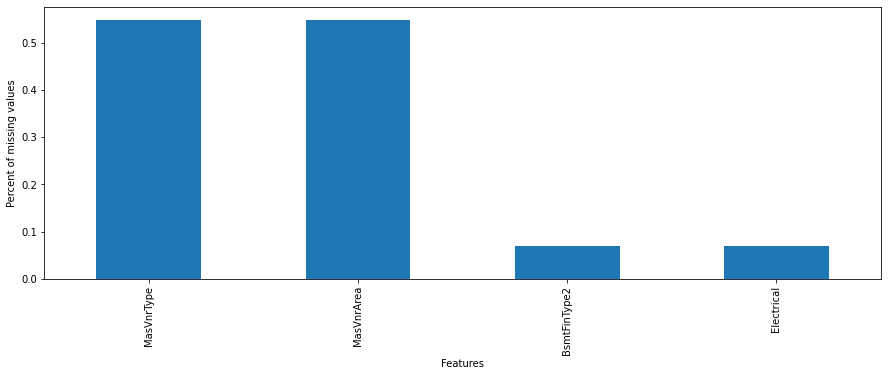

Процент пропущенных значений в столбцах
MasVnrType      0.547945
MasVnrArea      0.547945
BsmtFinType2    0.068493
Electrical      0.068493
dtype: float64
------------------------------------------------
MasVnrType object
MasVnrArea float64
BsmtFinType2 object
Electrical object


In [61]:
ProcentOfMissingValue(data_train)

    10. MasVnrType Тип каменной кладки
        MasVnrArea Площадь каменной кладки в квадратных футах.

In [62]:
index_ = data_train.loc[data_train[(data_train['MasVnrType'].isna() == True) & (data_train['MasVnrArea'].isna() == True)].index][['MasVnrType','MasVnrArea']].index
rows_ = ['MasVnrType']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [63]:
data_train['MasVnrType'].value_counts()

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [64]:
index_ = data_train.loc[data_train[(data_train['MasVnrArea'].isna() == True)].index][['MasVnrArea']].index
rows_ = ['MasVnrArea']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna(0)

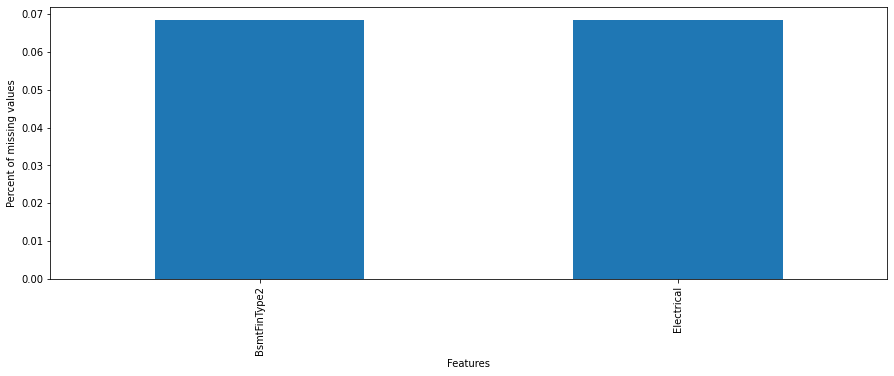

Процент пропущенных значений в столбцах
BsmtFinType2    0.068493
Electrical      0.068493
dtype: float64
------------------------------------------------
BsmtFinType2 object
Electrical object


In [65]:
ProcentOfMissingValue(data_train)

    11. BsmtFinType2 Качество второй обработанной области (если присутствует)
    Electrical Электрическая система

In [66]:
data_train.loc[data_train[(data_train['BsmtFinType2'].isna() == True)|(data_train['Electrical'].isna() == True)].index][['BsmtFinType2','Electrical']]
# data_train[['BsmtFinType2','Electrical']]

BsmtFinType2 Electrical
332           NaN      SBrkr
1379          Unf        NaN

In [67]:
data_train[data_train['BsmtFinType2'] == 'Unf'][['BsmtFinType2','Electrical']].value_counts()

BsmtFinType2  Electrical
Unf           SBrkr         1153
              FuseA           79
              FuseF           20
              FuseP            2
              Mix              1
dtype: int64

In [68]:
index_ = data_train.loc[data_train[(data_train['Electrical'].isna() == True)].index][['Electrical']].index
print(index_)
rows_ = ['Electrical']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('SBrkr')

Int64Index([1379], dtype='int64')


In [69]:
data_train.loc[1379,'Electrical']

'SBrkr'

In [70]:
data_train[data_train['Electrical'] == 'SBrkr'][['BsmtFinType2','Electrical']].value_counts()

BsmtFinType2  Electrical
Unf           SBrkr         1154
Rec           SBrkr           50
LwQ           SBrkr           45
BLQ           SBrkr           29
None          SBrkr           24
ALQ           SBrkr           18
GLQ           SBrkr           14
dtype: int64

In [71]:
index_ = data_train.loc[data_train[(data_train['BsmtFinType2'].isna() == True)].index][['BsmtFinType2']].index
print(index_)
rows_ = ['BsmtFinType2']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('Unf')

Int64Index([332], dtype='int64')


In [72]:
data_train.loc[332,'BsmtFinType2']

'Unf'

Проверяем на наличие пропущенных значений

In [73]:
data_train.isna().sum().sum()

0

Мы получили чистый датасет, без пропущенных значений

**Описание наименований столбцов**
- SalePrice: цена продажи недвижимости в долларах. Это целевая переменная, которую вы пытаетесь предсказать.
- MSSubClass: класс здания
- MSZoning: Общая классификация зонирования
- LotFrontage: Линейные футы улицы, соединенной с недвижимостью
- LotArea: Размер участка в квадратных футах.
- Улица: Тип подъездной дороги
- Аллея: Тип доступа к аллее
- LotShape: Общий вид недвижимости
- LandContour: Плоскостность объекта
- Утилиты: Тип доступных утилит
- LotConfig: конфигурация лота
- LandSlope: уклон участка
- Окрестности: физические местоположения в черте города Эймс.
- Условие 1: Близость к главной дороге или железной дороге
- Условие 2: близость к главной дороге или железной дороге (при наличии второй)
- BldgType: Тип жилья
- HouseStyle: стиль жилья
- Общее качество: общее качество материала и отделки.
- TotalCond: общая оценка состояния
- Год постройки: Первоначальная дата постройки
- YearRemodAdd: дата переделки
- RoofStyle: тип крыши
- RoofMatl: Материал крыши
- Exterior1st: Внешнее покрытие дома
- Exterior2nd: Внешнее покрытие дома (если более одного материала)
- MasVnrType: Тип каменной кладки
- MasVnrArea: Площадь каменной кладки в квадратных футах.
- ExterQual: качество материалов экстерьера
- ExterCond: Текущее состояние материала снаружи.
- Фундамент: Тип фундамента
- BsmtQual: Высота подвала
- BsmtCond: Общее состояние подвала
- BsmtExposure: Стены подвала на уровне выхода или сада.
- BsmtFinType1: Качество отделки цокольного этажа
- BsmtFinSF1: тип 1 с отделкой в квадратных футах
- BsmtFinType2: Качество второй обработанной области (если присутствует)
- BsmtFinSF2: тип 2 с отделкой в квадратных футах
- BsmtUnfSF: Незавершенные квадратные футы цокольного этажа.
- TotalBsmtSF: Общая площадь подвала в квадратных футах.
- Отопление: Тип отопления
- ОтоплениеQC: Качество и состояние отопления
- CentralAir: центральное кондиционирование
- Электрика: Электрическая система
- 1stFlrSF: квадратные футы первого этажа
- 2ndFlrSF: Квадратные футы второго этажа.
- LowQualFinSF: квадратные футы с отделкой низкого качества (все этажи)
- GrLivArea: жилая площадь над землей в квадратных футах
- BsmtFullBath: Ванные комнаты в подвале
- BsmtHalfBath: Половина ванных комнат в подвале
- FullBath: полностью оборудованные ванные комнаты выше уровня земли.
- HalfBath: полуванны выше уровня
- Спальня: Количество спален выше цокольного этажа
- Кухня: Количество кухонь
- KitchenQual: Качество кухни
- TotRmsAbvGrd: Общее количество комнат выше класса (не включая ванные комнаты)
- Функциональность: рейтинг домашней функциональности
- Камины: Количество каминов
- FireplaceQu: качество камина
- GarageType: Место в гараже
- GarageYrBlt: Год постройки гаража.
- GarageFinish: Внутренняя отделка гаража
- GarageCars: Размер гаража по вместимости автомобиля
- GarageArea: Размер гаража в квадратных футах.
- GarageQual: качество гаража
- GarageCond: Гаражное состояние
- PavedDrive: Асфальтированная дорога
- WoodDeckSF: площадь деревянной палубы в квадратных футах.
- OpenPorchSF: площадь открытого крыльца в квадратных футах.
- EnclosedPorch: закрытая площадь крыльца в квадратных футах.
- 3SsnPorch: площадь крыльца для трех сезонов в квадратных футах.
- ScreenPorch: Площадь крыльца в квадратных футах.
- PoolArea: Площадь бассейна в квадратных футах.
- PoolQC: качество пула
- Забор: Качество забора
- MiscFeature: Разная функция, не включенная в другие категории.
- MiscVal: Значение различных функций
- MoSold: месяц продажи
- Год продажи: Год продажи
- SaleType: Тип продажи
- Состояние продажи: Состояние продажи

**Строим диаграмму распределений исходного датасета и проводим описание данных**

Рисунок № 1. Диаграмма распределений значений цены

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


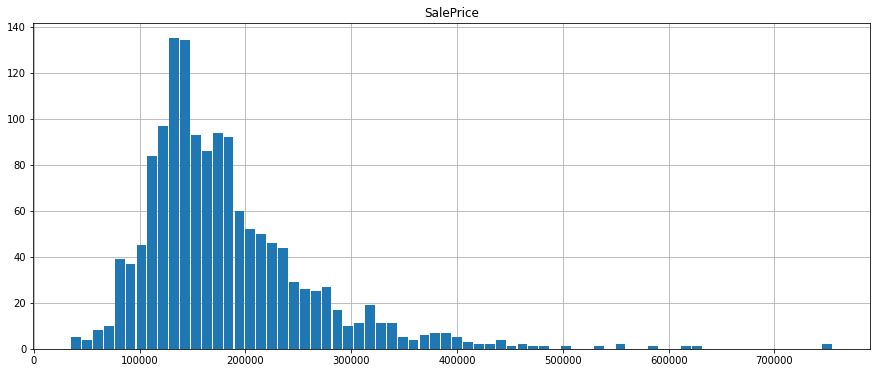

In [74]:
data_train.hist(column = 'SalePrice', bins = 70,figsize=(15,6), zorder=2, rwidth=0.9)
print(data_train['SalePrice'].describe())

**Строим диаграмму размаха цены исходного датасета**

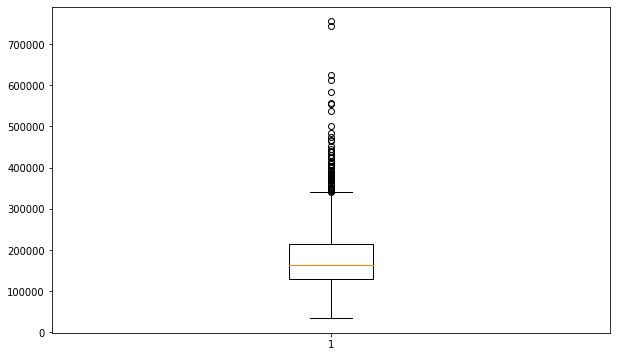

In [75]:
plt.figure(figsize=(10,6))
plt.boxplot(x=data_train['SalePrice'])
plt.show()

**Строим диаграмму рассеивания**

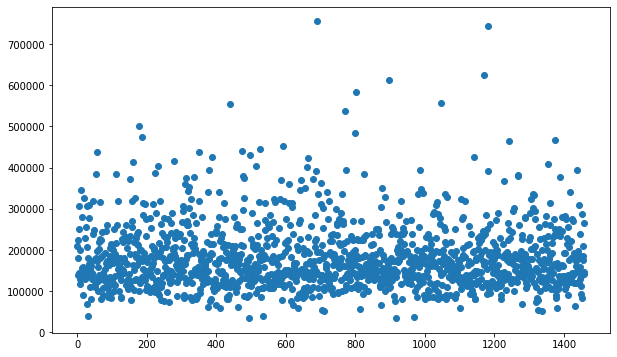

In [76]:
plt.figure(figsize=(10,6))
plt.scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
plt.show()

**Определяем типы данных присутствующие в датасете**

In [77]:
print('В датафрейме содержатся типы данных: ', data_train.dtypes.unique())
print('Количество столбцов типа int64: ', data_train.dtypes[data_train.dtypes == 'int64'].count())
print('Количество столбцов типа objects (O) : ', data_train.dtypes[data_train.dtypes == 'O'].count())
print('Количество столбцов типа float64 : ', data_train.dtypes[data_train.dtypes == 'float64'].count())

В датафрейме содержатся типы данных:  [dtype('int64') dtype('O') dtype('float64')]
Количество столбцов типа int64:  34
Количество столбцов типа objects (O) :  43
Количество столбцов типа float64 :  3


**Преобразование катигориальных данных в цифровые**

В связи с тем, что имы имеем катигориальные данные, а нейронные сети работают с цифрами, необходимо произвести их преобразование

In [78]:
ctr = 0
for i in data_train.dtypes[data_train.dtypes == 'O'].index:
    ctr = ctr + len(data_train[i].value_counts().index)
print('После преобразования мы должны получить количество столбцов: ', len(data_train.columns) - len(data_train.dtypes[data_train.dtypes == 'O'].index) + ctr)

После преобразования мы должны получить количество столбцов:  303


In [79]:
# Функция преобразования категориальных значений в цифровые
def ConvertCatToNum(data):
    data_ = data
    if(data.dtypes[data.dtypes == 'O'].count() == 0):
        return data
    if(data.dtypes[data.dtypes == 'O'].count() > 0):
        index = data.dtypes[data.dtypes == 'O'].index.tolist()
        for i in index:
#             futurs = 
#             futurs = pd.get_dummies(data[i]).reset_index(drop=True)
            data_ = pd.concat([data_,
                   pd.get_dummies(data_[i], prefix = i).reset_index(drop=True)],
                  axis = 1)
            data_ = data_.drop(i,axis=1)
        return data_

In [80]:
data_train = ConvertCatToNum(data_train)

На выходе мы получаем преобразованные катигориальные данные, добавленные к существующему датфрейму и удаленные столбцы катигориальных данных.

**Проверяем сохранность количества строк**

In [81]:
data_train

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

Как можно увидеть, количество строк совпадает

**Проверяем на наличие столбцов с типом object**

In [82]:
print('В датафрейме содержатся типы данных: ', data_train.dtypes.unique())

В датафрейме содержатся типы данных:  [dtype('int64') dtype('float64') dtype('uint8')]


В датафрейме отсутствуют типы данных object

**Проверяем корреляцию между выходной переменной и входными (измерение влияния факторов на выходную переменную)**

**Производим отбор переменных (признаков**

Отличная статья: https://loginom.ru/blog/feature-selection

В данной работе был выбран метод использующий корреляцию между входными переменными и выходной. 

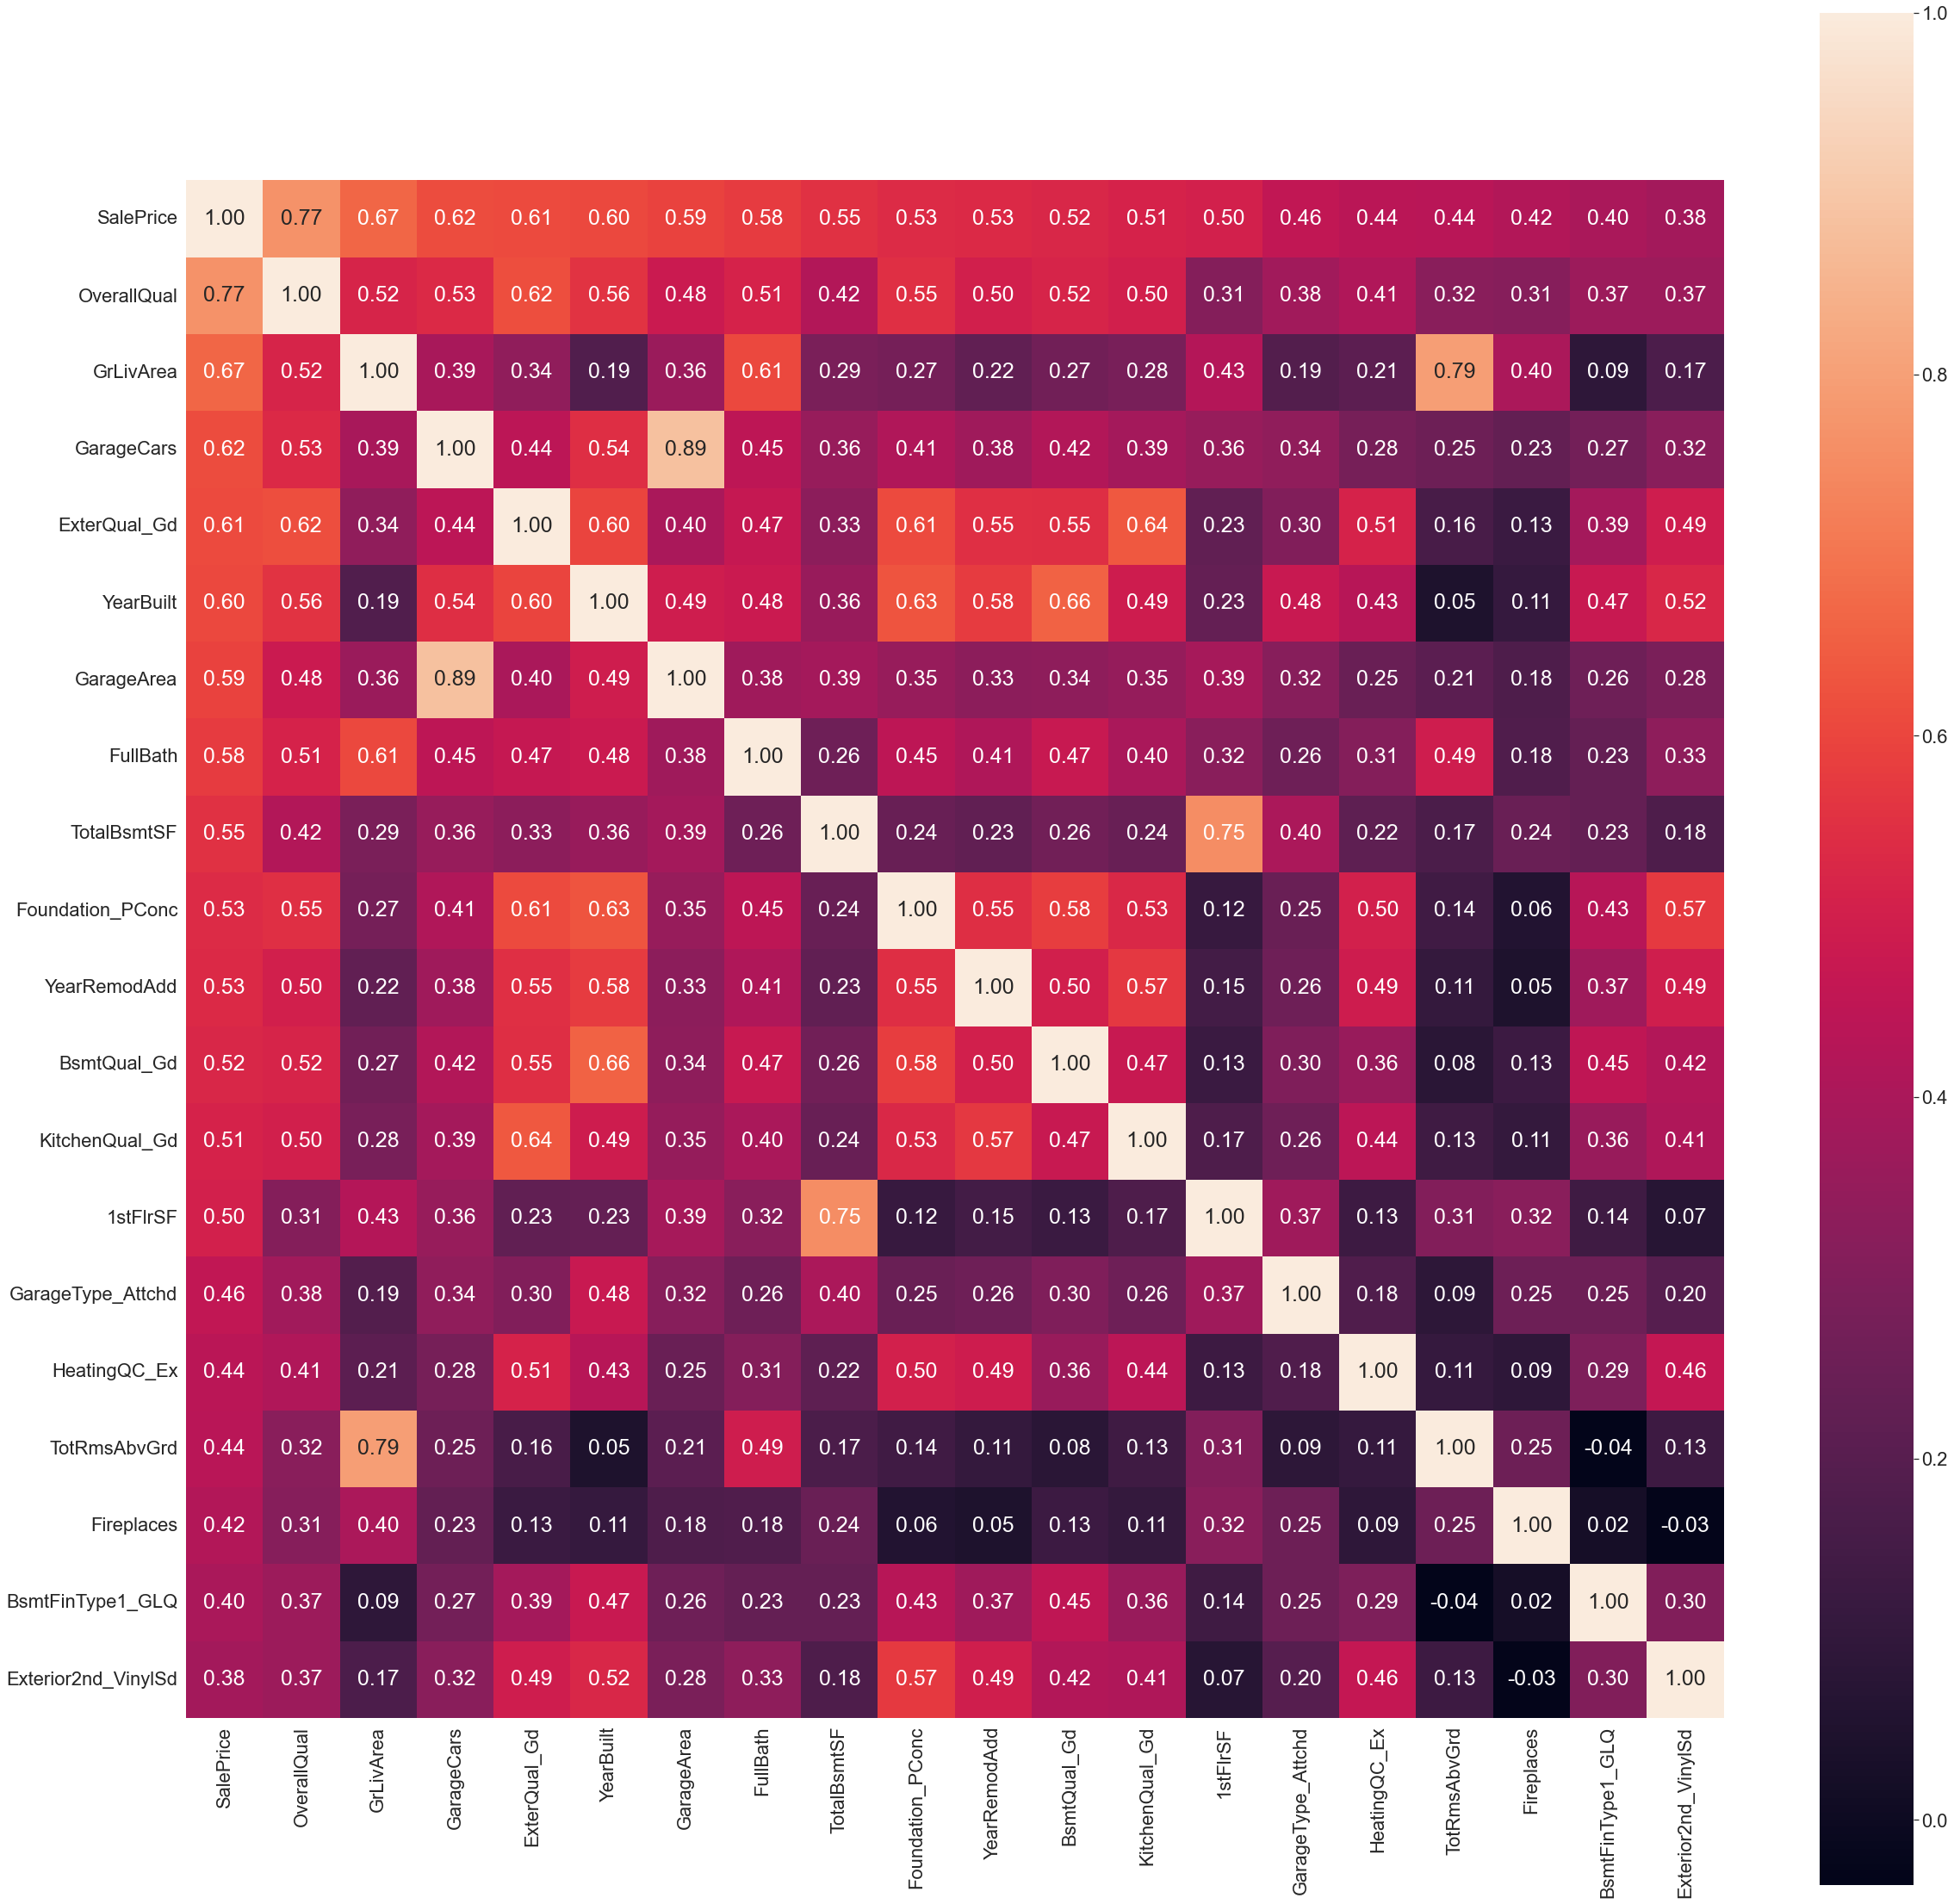

In [147]:
corrmat = data_train.corr()
k = 20 # количество коррелирующих признаков, которое мы хотим увидеть
corrmat.nlargest(k, 'SalePrice').index #Отображаем столбцы максимальной корреляции по возрастанию
cols = corrmat.nlargest(k, 'SalePrice').index
cm = np.corrcoef(data_train[cols].values.T)
plt.figure(figsize=(k+20,k+20))
sns.set(font_scale=2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 25}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Строим графики расределений максимально коррелиремых значений с ценой, а также диаграмму размаха для каждого значения**

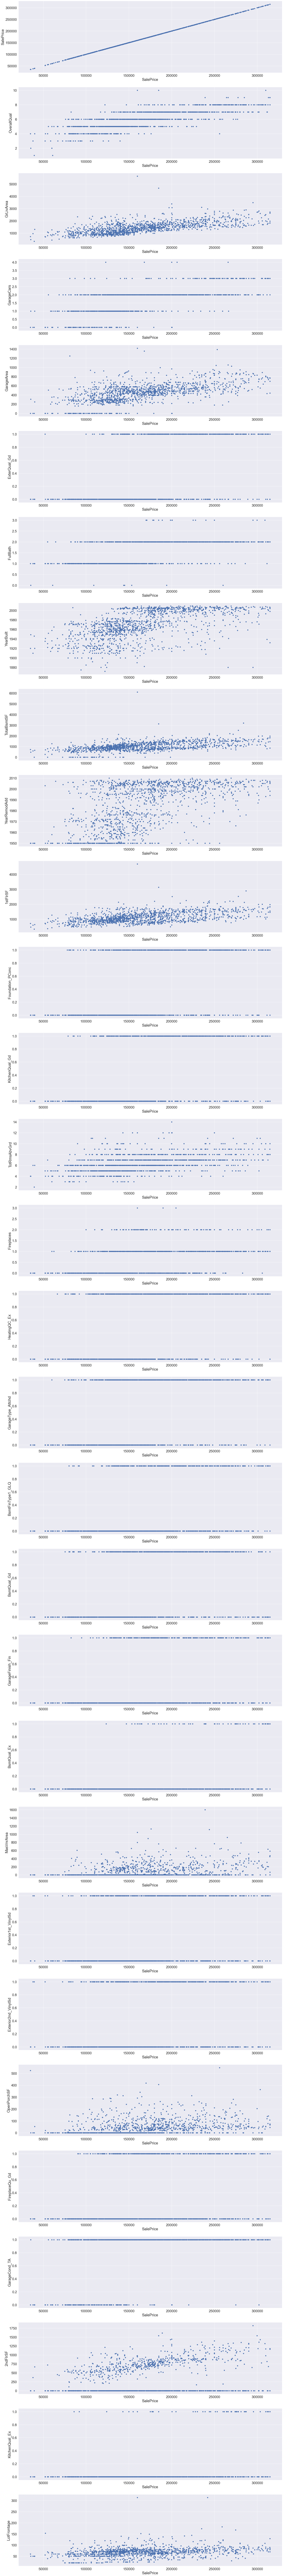

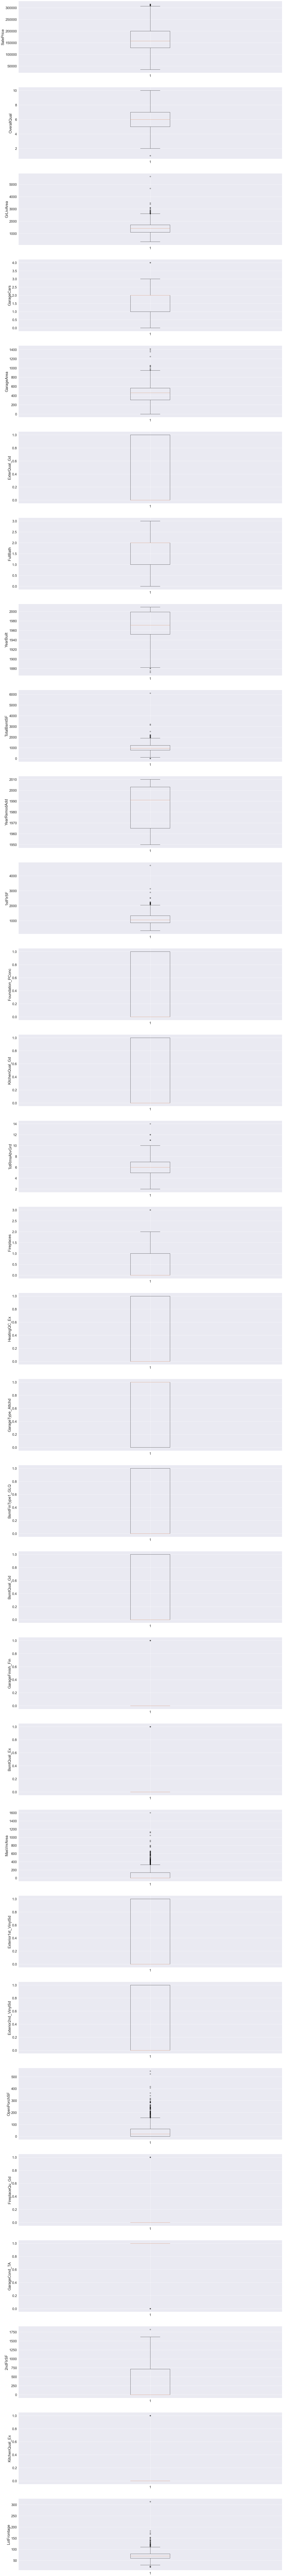

In [94]:
fig, axs = plt.subplots(nrows = len(corrmat.nlargest(k, 'SalePrice').index)  , ncols= 1 ,figsize=(30,300))
for ctn, i in enumerate(corrmat.nlargest(k, 'SalePrice').index):
    axs[ctn].scatter(data_train['SalePrice'], data_train[i])
    axs[ctn].set_xlabel('SalePrice')
    axs[ctn].set_ylabel(i)

fig_1, axs_1 = plt.subplots(nrows = len(corrmat.nlargest(k, 'SalePrice').index)  , ncols= 1 ,figsize=(30,300))
for ctn, i in enumerate(corrmat.nlargest(k, 'SalePrice').index):
    axs_1[ctn].boxplot(data_train[i])
    axs_1[ctn].set_ylabel(i)

plt.show()

Можно наблюдать, что данные имеют большое количество выбросов. Соответстенно необходимо реализовать их фильтрацию, обратившись к рисунку № 1, можно заметить, что распределение имеет не симметричные хвосты, соответственно мы не може применять **метод стандартного отклонения**. По этому было принято решение использовать **Метод интерквартильных расстояний**.
Для реализации данного метода, нам необходимо найти первый (Q1) и третий (Q3) квартил, и на основе них найти "экстримальные" значения по формулам: Limmax = Q3 + Ni х IQR; Limmin = Q1 - Ni х IQR; где Q3 - третий квартиль, Q1 - первый квартиль, IQR - интерквартильное расстояние определяемое по формуле IQR = Q3 - Q1; Ni - заданное число интерквартильного размаха (1.5).

**Производим метод интерквартильных расстояний и фильтруем данные**

In [95]:
# for ctr, i in enumerate(data_train[corrmat.nlargest(k, 'SalePrice').index.drop('SalePrice')].columns):
#     Q1 = q1(data_train[i])
#     Q3 = q3(data_train[i])
#     IQR = Q3 - Q1
#     min_ = Q1 - 1.5 * IQR
#     max_ = Q3 + 1.5 * IQR
#     data_train.hist(column = i, bins = 10,figsize=(15,6), zorder=2, rwidth=0.9)
# #     data_train = data_train.drop(data_train[((data_train[i] > min_) & (data_train[i] < max_))].index)
#     print(i, '-' , 'Q1: ',Q1, ';', 'Q3: ', Q3,';', 'IQR:', IQR, ';' ,'min:', abs(Q1 - 1.5*IQR),'max:', abs(Q3 + 1.5*IQR))



**Ручная подготовка данных**

Очистка SalePrice

In [98]:
#Функция рассчета первого квартиля
def q1(x):
    return np.quantile(x, 0.25 )
#Функция рассчета второго квартиля
def q3(x):
    return np.quantile(x, 0.75)

Q1 = q1(data_train['SalePrice'])
Q3 = q3(data_train['SalePrice'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('SalePrice Q1', Q1)
print('SalePrice Q3', Q3)
print('SalePrice IQR', IQR)
print('SalePrice min', min_)
print('SalePrice max', max_)
# data_train = data_train.drop(data_train[((data_train['SalePrice'] > min_) & (data_train['SalePrice'] < max_))].index)



SalePrice Q1 128000.0
SalePrice Q3 197000.0
SalePrice IQR 69000.0
SalePrice min 24500.0
SalePrice max 300500.0


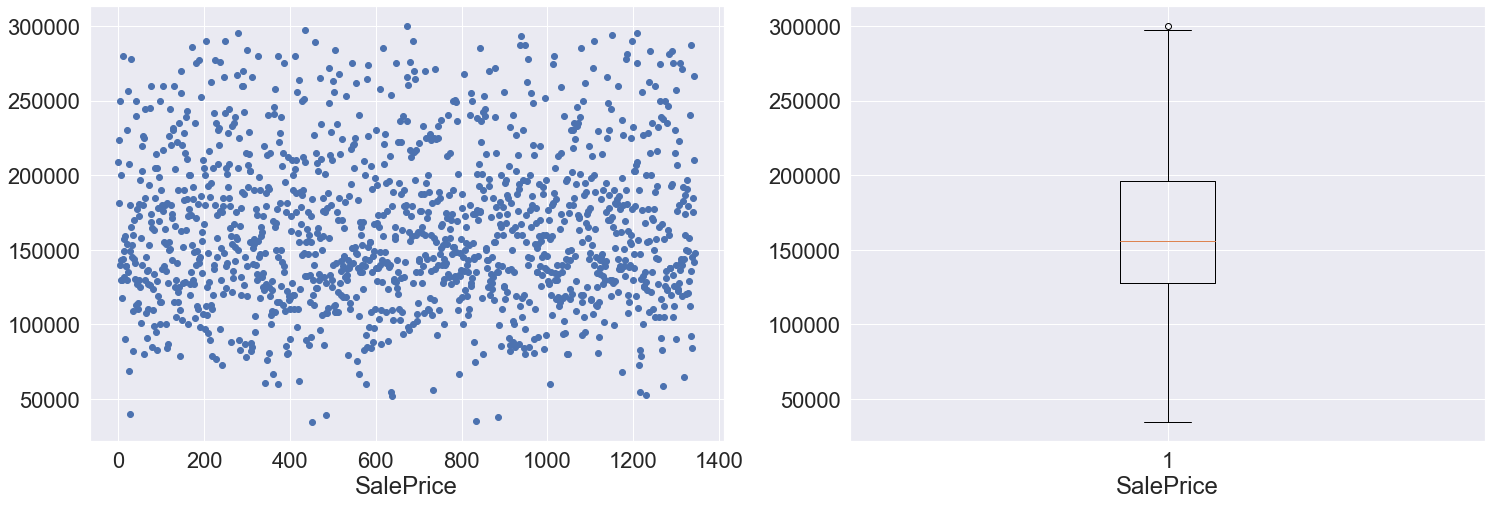

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [99]:
data_train = data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 2 ,figsize=(25,8))

aix[0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[1].boxplot(data_train['SalePrice'])
aix[0].set_xlabel('SalePrice')
aix[1].set_xlabel('SalePrice')
plt.show()
data_train

Очистка OverallQual

In [100]:
Q1 = q1(data_train['OverallQual'])
Q3 = q3(data_train['OverallQual'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('OverallQual Q1', Q1)
print('OverallQual Q3', Q3)
print('OverallQual IQR', IQR)
print('OverallQual min', min_)
print('OverallQual max', max_)

OverallQual Q1 5.0
OverallQual Q3 7.0
OverallQual IQR 2.0
OverallQual min 2.0
OverallQual max 10.0


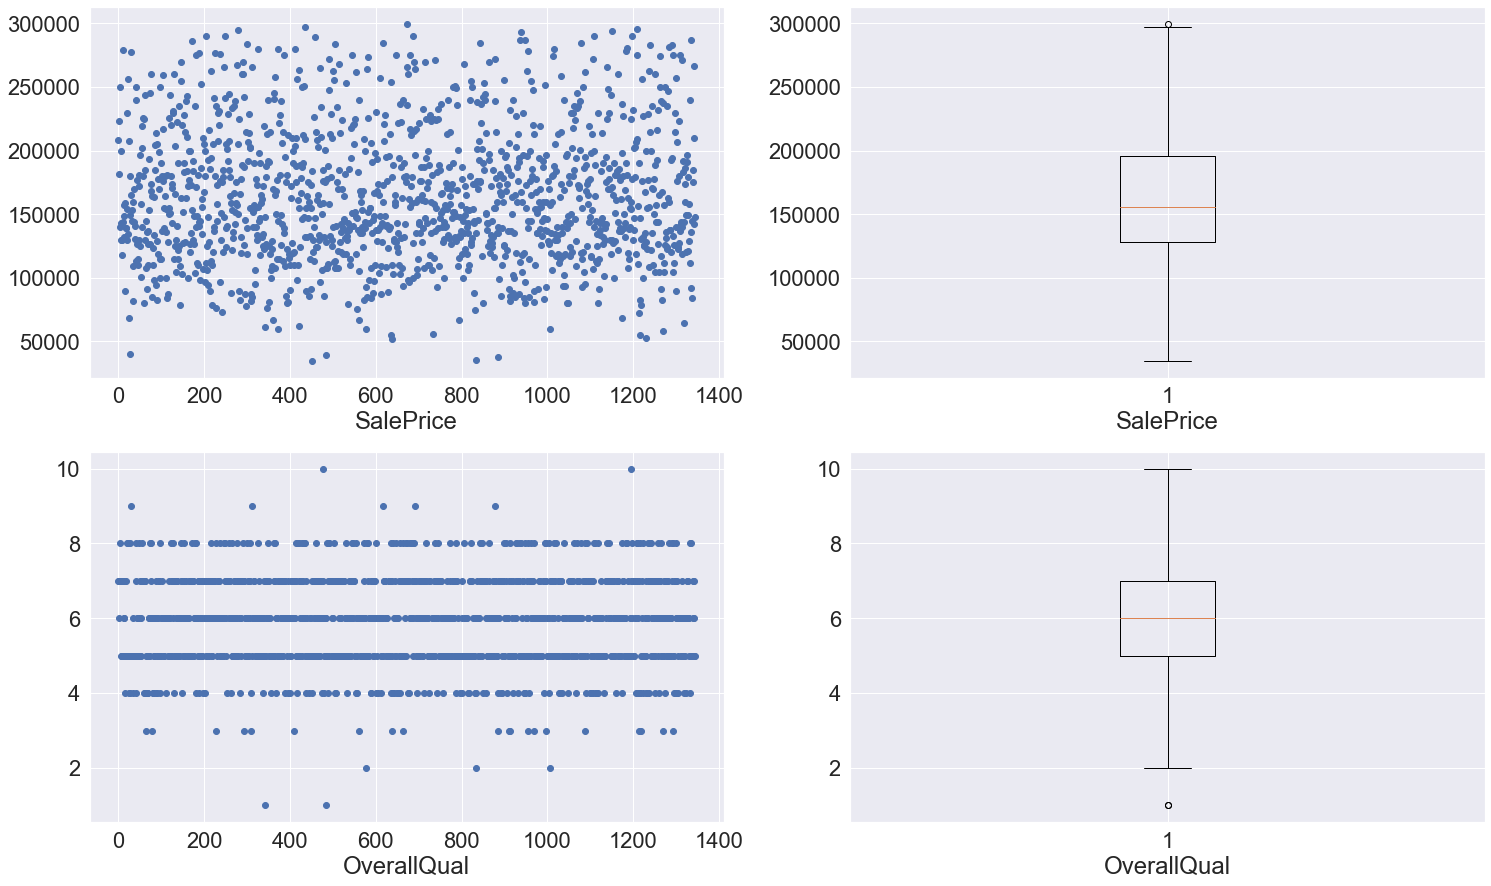

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [101]:
data_train = data_train.drop(data_train[((max_ < data_train['OverallQual'])) & ((data_train['OverallQual'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['OverallQual'].size)),
                       y = data_train['OverallQual'].tolist())
aix[1,0].set_xlabel('OverallQual')
aix[1,1].boxplot(data_train['OverallQual'])
aix[1,1].set_xlabel('OverallQual')
plt.show()
data_train

Очистка GrLivArea

In [102]:
Q1 = q1(data_train['GrLivArea'])
Q3 = q3(data_train['GrLivArea'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GrLivArea Q1', Q1)
print('GrLivArea Q3', Q3)
print('GrLivArea IQR', IQR)
print('GrLivArea min', min_)
print('GrLivArea max', max_)

GrLivArea Q1 1110.0
GrLivArea Q3 1708.0
GrLivArea IQR 598.0
GrLivArea min 213.0
GrLivArea max 2605.0


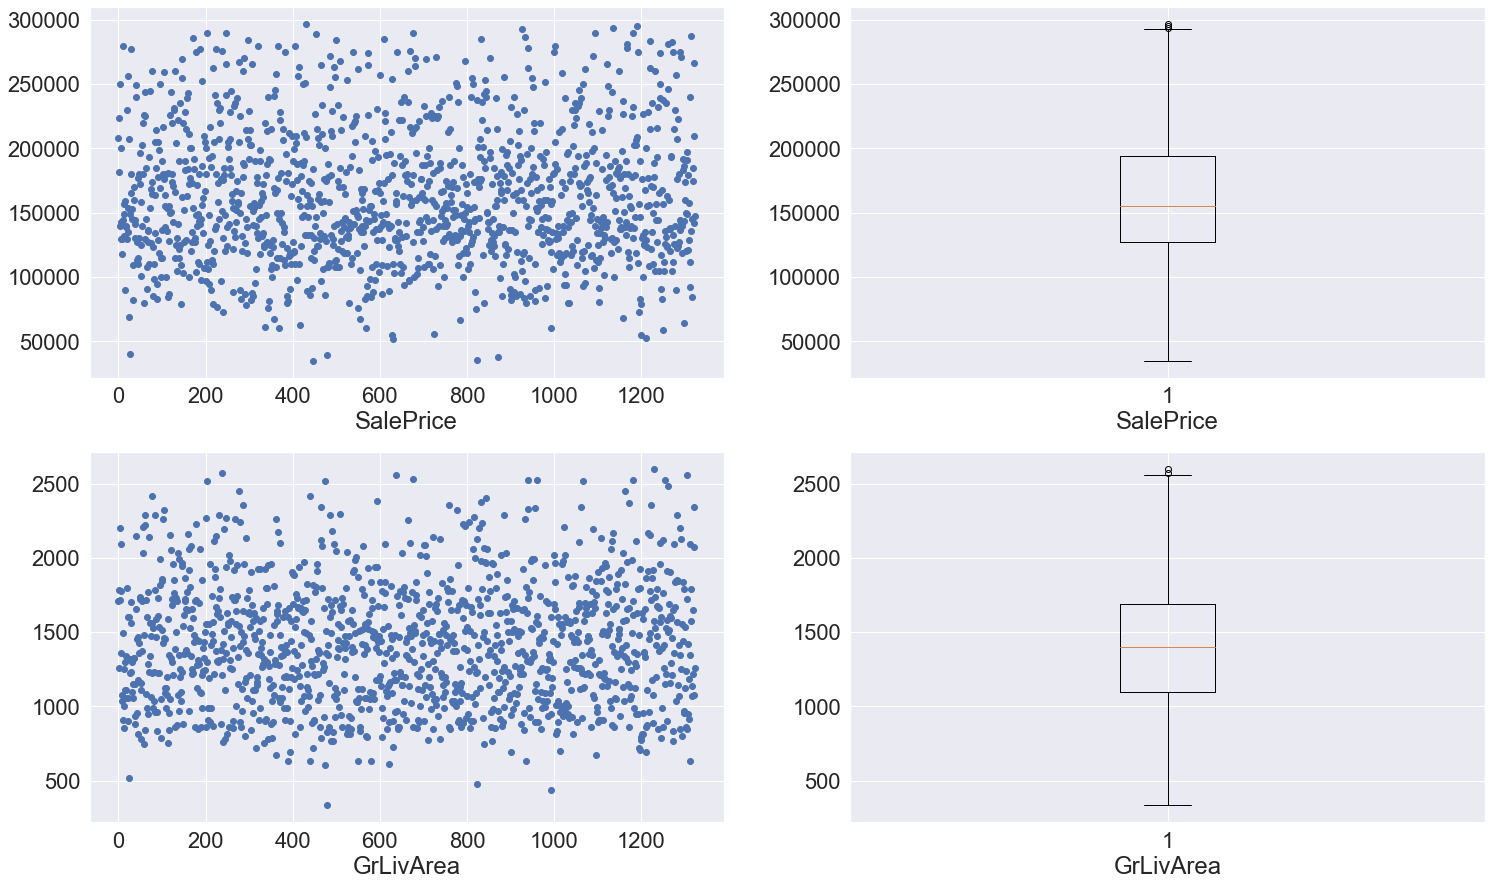

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [103]:
data_train = data_train.drop(data_train[((max_ < data_train['GrLivArea'])) & ((data_train['GrLivArea'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['GrLivArea'].size)),
                       y = data_train['GrLivArea'].tolist())
aix[1,0].set_xlabel('GrLivArea')
aix[1,1].boxplot(data_train['GrLivArea'])
aix[1,1].set_xlabel('GrLivArea')
plt.show()
data_train

Очистка GarageCars

In [25]:
# list(data_train[corrmat.nlargest(k, 'SalePrice').index].columns)

In [26]:
Q1 = q1(data_train['GarageCars'])
Q3 = q3(data_train['GarageCars'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GrLivArea Q1', Q1)
print('GrLivArea Q3', Q3)
print('GrLivArea IQR', IQR)
print('GrLivArea min', min_)
print('GrLivArea max', max_)

GrLivArea Q1 1.0
GrLivArea Q3 2.0
GrLivArea IQR 1.0
GrLivArea min -0.5
GrLivArea max 3.5


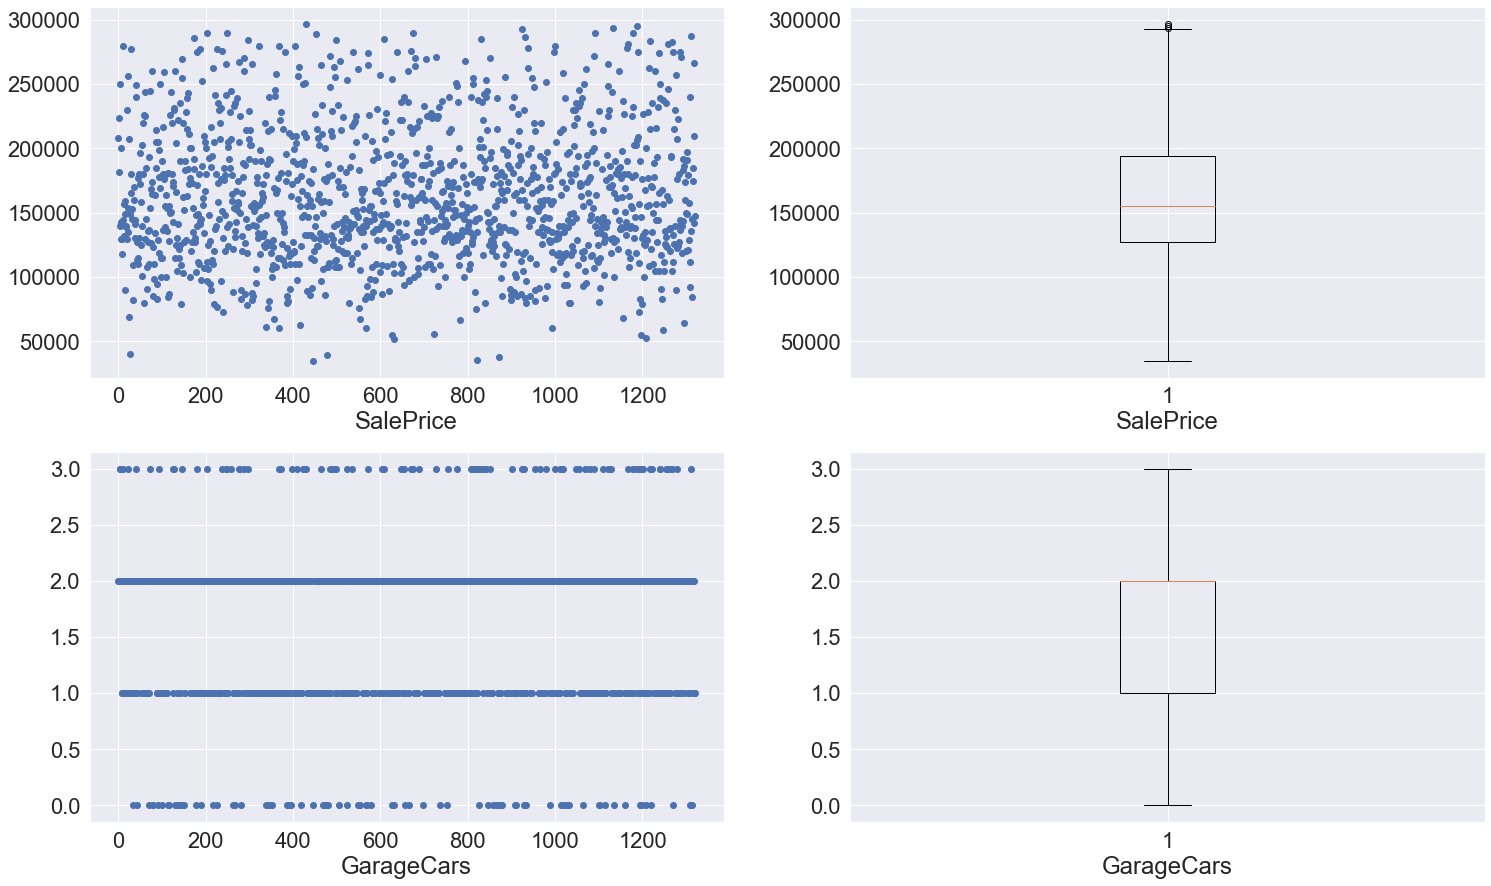

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1456          20       RL         85.0    13175   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1455         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1456         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1458         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0          0      2    2008        WD         Normal     208500  
1          0      5    2007        WD         Normal     181500  
2          0      9    2008        WD         Normal     223500  
3          0      2    2006        WD        Abnorml     140000  
4          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1455       0      8    2007        WD         Normal     175000  
1456       0      2    2010        WD         Normal     210000  
1457    2500      5    2010        WD         Normal     266500  
1458       0      4    2010        WD         Normal     142125  
1459       0      6    2008        WD         Normal     147500  

[1321 rows x 80 columns]

In [27]:
data_train = data_train.drop(data_train[((max_ < data_train['GarageCars'])) & ((data_train['GarageCars'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['GarageCars'].size)),
                       y = data_train['GarageCars'].tolist())
aix[1,0].set_xlabel('GarageCars')
aix[1,1].boxplot(data_train['GarageCars'])
aix[1,1].set_xlabel('GarageCars')
plt.show()
data_train

Очистка GarageArea

In [104]:
Q1 = q1(data_train['GarageArea'])
Q3 = q3(data_train['GarageArea'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GarageArea Q1', Q1)
print('GarageArea Q3', Q3)
print('GarageArea IQR', IQR)
print('GarageArea min', min_)
print('GarageArea max', max_)

GarageArea Q1 308.0
GarageArea Q3 552.0
GarageArea IQR 244.0
GarageArea min -58.0
GarageArea max 918.0


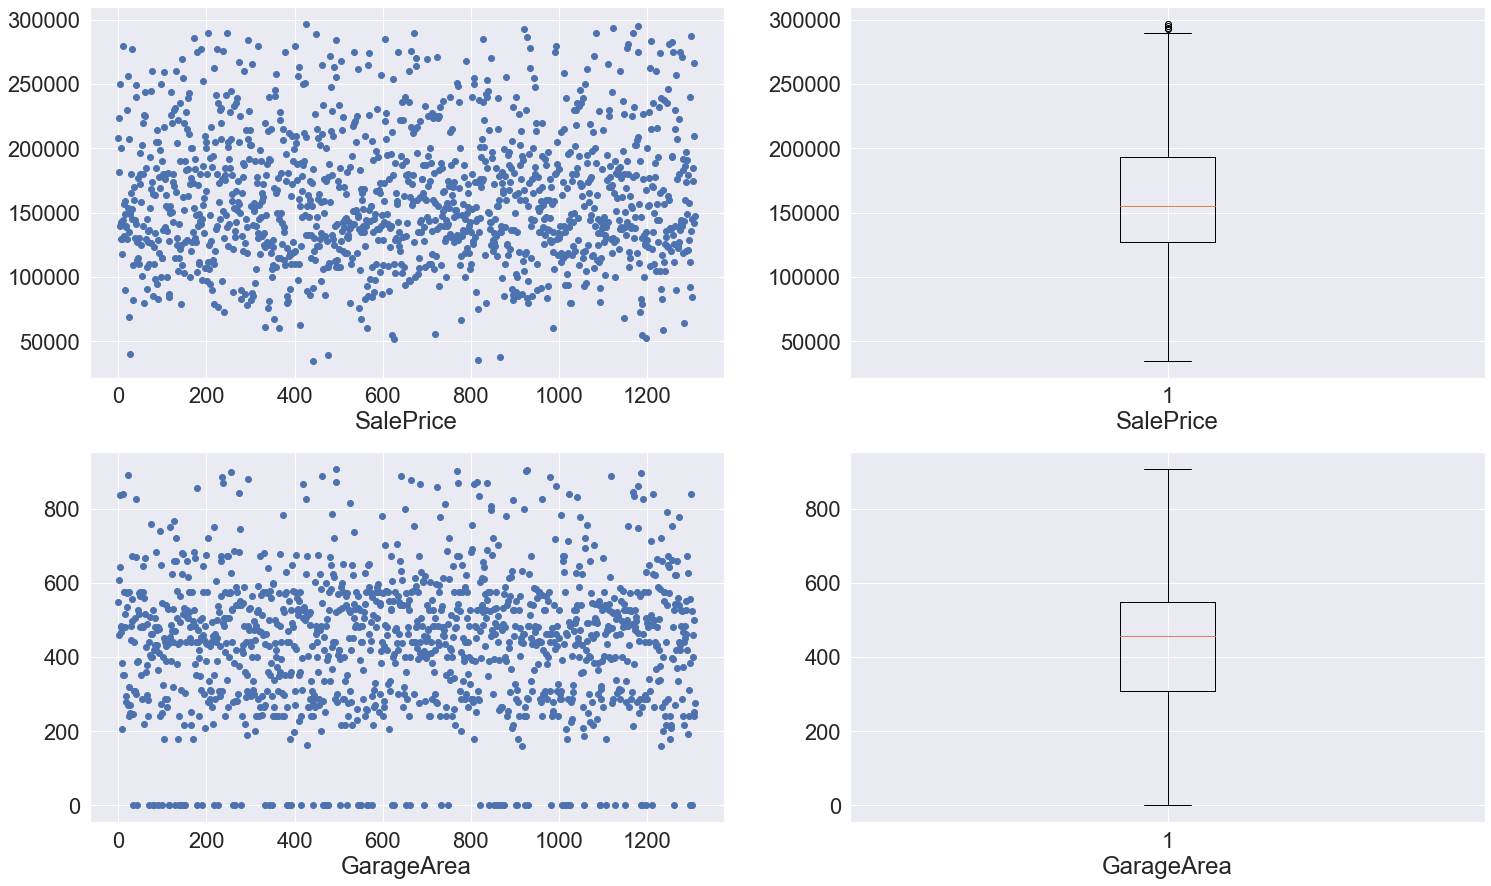

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [105]:
data_train = data_train.drop(data_train[((max_ < data_train['GarageArea'])) & ((data_train['GarageArea'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['GarageArea'].size)),
                       y = data_train['GarageArea'].tolist())
aix[1,0].set_xlabel('GarageArea')
aix[1,1].boxplot(data_train['GarageArea'])
aix[1,1].set_xlabel('GarageArea')
plt.show()
data_train

Очистка TotalBsmtSF

In [30]:
Q1 = q1(data_train['TotalBsmtSF'])
Q3 = q3(data_train['TotalBsmtSF'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('TotalBsmtSF Q1', Q1)
print('TotalBsmtSF Q3', Q3)
print('TotalBsmtSF IQR', IQR)
print('TotalBsmtSF min', min_)
print('TotalBsmtSF max', max_)

TotalBsmtSF Q1 777.75
TotalBsmtSF Q3 1208.0
TotalBsmtSF IQR 430.25
TotalBsmtSF min 132.375
TotalBsmtSF max 1853.375


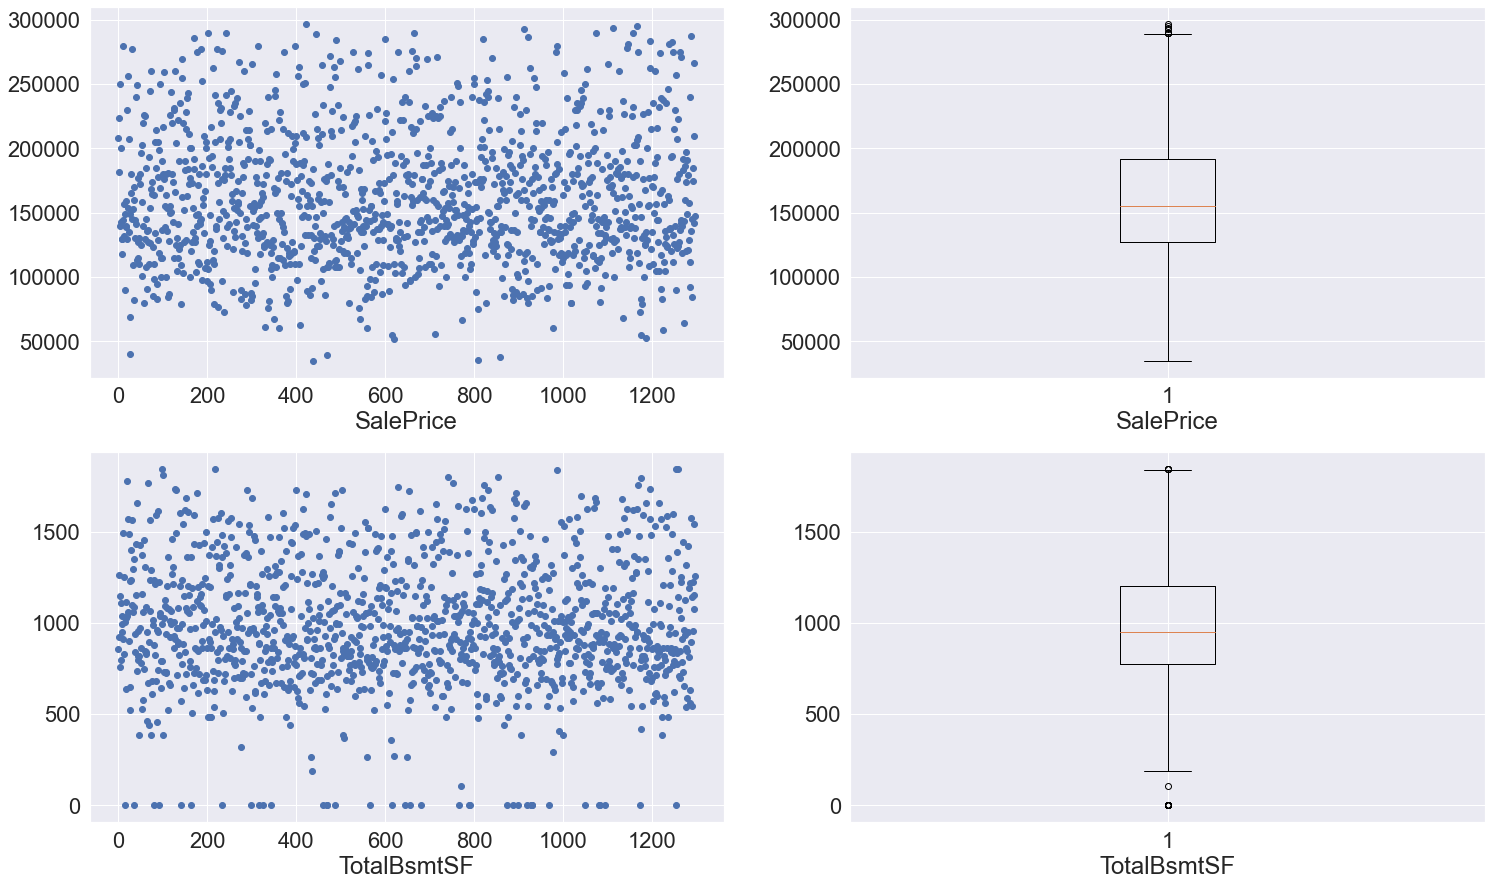

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1456          20       RL         85.0    13175   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1455         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1456         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1458         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0          0      2    2008        WD         Normal     208500  
1          0      5    2007        WD         Normal     181500  
2          0      9    2008        WD         Normal     223500  
3          0      2    2006        WD        Abnorml     140000  
4          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1455       0      8    2007        WD         Normal     175000  
1456       0      2    2010        WD         Normal     210000  
1457    2500      5    2010        WD         Normal     266500  
1458       0      4    2010        WD         Normal     142125  
1459       0      6    2008        WD         Normal     147500  

[1297 rows x 80 columns]

In [31]:
data_train = data_train.drop(data_train[((max_ < data_train['TotalBsmtSF'])) & ((data_train['TotalBsmtSF'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['TotalBsmtSF'].size)),
                       y = data_train['TotalBsmtSF'].tolist())
aix[1,0].set_xlabel('TotalBsmtSF')
aix[1,1].boxplot(data_train['TotalBsmtSF'])
aix[1,1].set_xlabel('TotalBsmtSF')
plt.show()
data_train

Очистка 1stFlrSF

In [32]:
Q1 = q1(data_train['1stFlrSF'])
Q3 = q3(data_train['1stFlrSF'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('1stFlrSF Q1', Q1)
print('1stFlrSF Q3', Q3)
print('1stFlrSF IQR', IQR)
print('1stFlrSF min', min_)
print('1stFlrSF max', max_)

1stFlrSF Q1 864.0
1stFlrSF Q3 1297.0
1stFlrSF IQR 433.0
1stFlrSF min 214.5
1stFlrSF max 1946.5


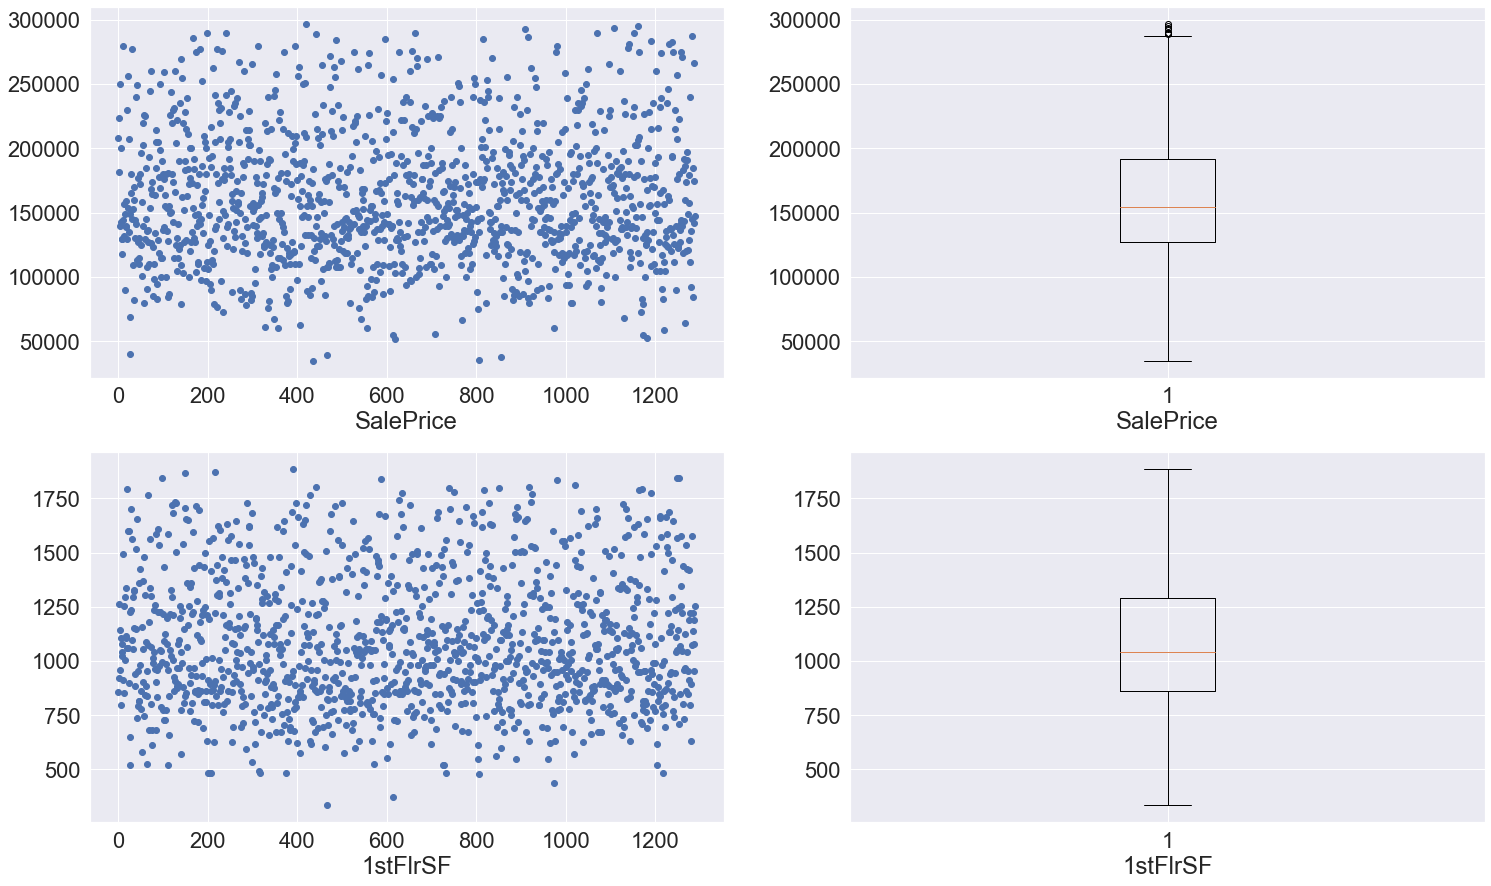

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1454          20       FV         62.0     7500   Pave  Pave      Reg   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1454         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1455         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1458         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0          0      2    2008        WD         Normal     208500  
1          0      5    2007        WD         Normal     181500  
2          0      9    2008        WD         Normal     223500  
3          0      2    2006        WD        Abnorml     140000  
4          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1454       0     10    2009        WD         Normal     185000  
1455       0      8    2007        WD         Normal     175000  
1457    2500      5    2010        WD         Normal     266500  
1458       0      4    2010        WD         Normal     142125  
1459       0      6    2008        WD         Normal     147500  

[1290 rows x 80 columns]

In [33]:
data_train = data_train.drop(data_train[((max_ < data_train['1stFlrSF'])) & ((data_train['1stFlrSF'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['1stFlrSF'].size)),
                       y = data_train['1stFlrSF'].tolist())
aix[1,0].set_xlabel('1stFlrSF')
aix[1,1].boxplot(data_train['1stFlrSF'])
aix[1,1].set_xlabel('1stFlrSF')
plt.show()
data_train

Очистка TotRmsAbvGrd

In [106]:
Q1 = q1(data_train['TotRmsAbvGrd'])
Q3 = q3(data_train['TotRmsAbvGrd'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('TotRmsAbvGrd Q1', Q1)
print('TotRmsAbvGrd Q3', Q3)
print('TotRmsAbvGrd IQR', IQR)
print('TotRmsAbvGrd min', min_)
print('TotRmsAbvGrd max', max_)

TotRmsAbvGrd Q1 5.0
TotRmsAbvGrd Q3 7.0
TotRmsAbvGrd IQR 2.0
TotRmsAbvGrd min 2.0
TotRmsAbvGrd max 10.0


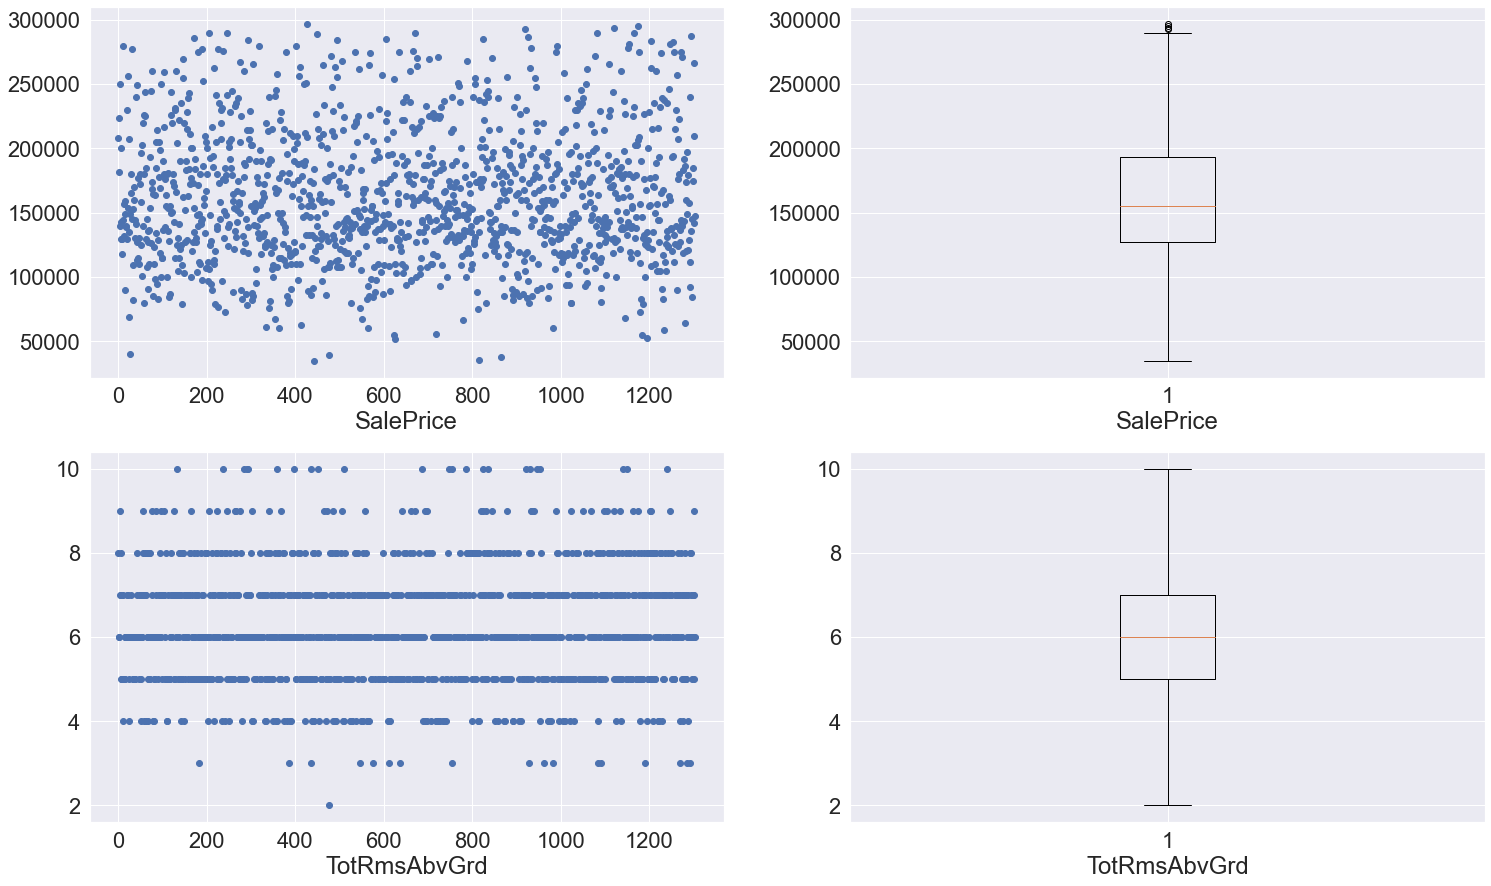

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [107]:
data_train = data_train.drop(data_train[((max_ < data_train['TotRmsAbvGrd'])) & ((data_train['TotRmsAbvGrd'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['TotRmsAbvGrd'].size)),
                       y = data_train['TotRmsAbvGrd'].tolist())
aix[1,0].set_xlabel('TotRmsAbvGrd')
aix[1,1].boxplot(data_train['TotRmsAbvGrd'])
aix[1,1].set_xlabel('TotRmsAbvGrd')
plt.show()
data_train

In [ ]:
Очистка LotFrontage

In [120]:
Q1 = q1(data_train['LotFrontage'])
Q3 = q3(data_train['LotFrontage'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('LotFrontage Q1', Q1)
print('LotFrontage Q3', Q3)
print('LotFrontage IQR', IQR)
print('LotFrontage min', min_)
print('LotFrontage max', max_)

LotFrontage Q1 60.0
LotFrontage Q3 75.0
LotFrontage IQR 15.0
LotFrontage min 37.5
LotFrontage max 97.5


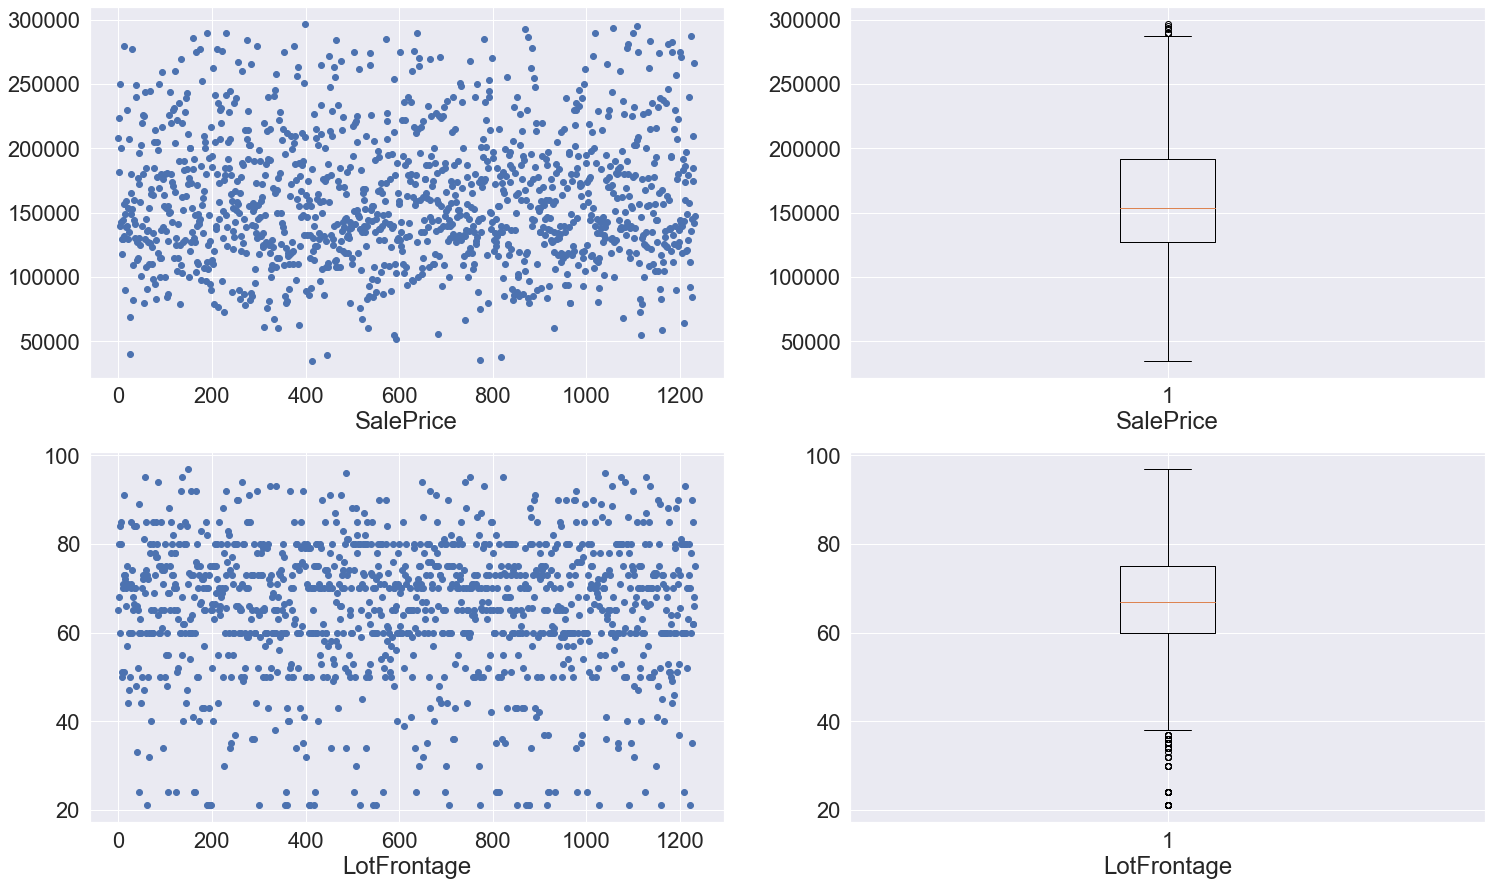

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [121]:
data_train = data_train.drop(data_train[((max_ < data_train['LotFrontage'])) & ((data_train['LotFrontage'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['LotFrontage'].size)),
                       y = data_train['LotFrontage'].tolist())
aix[1,0].set_xlabel('LotFrontage')
aix[1,1].boxplot(data_train['LotFrontage'])
aix[1,1].set_xlabel('LotFrontage')
plt.show()
data_train

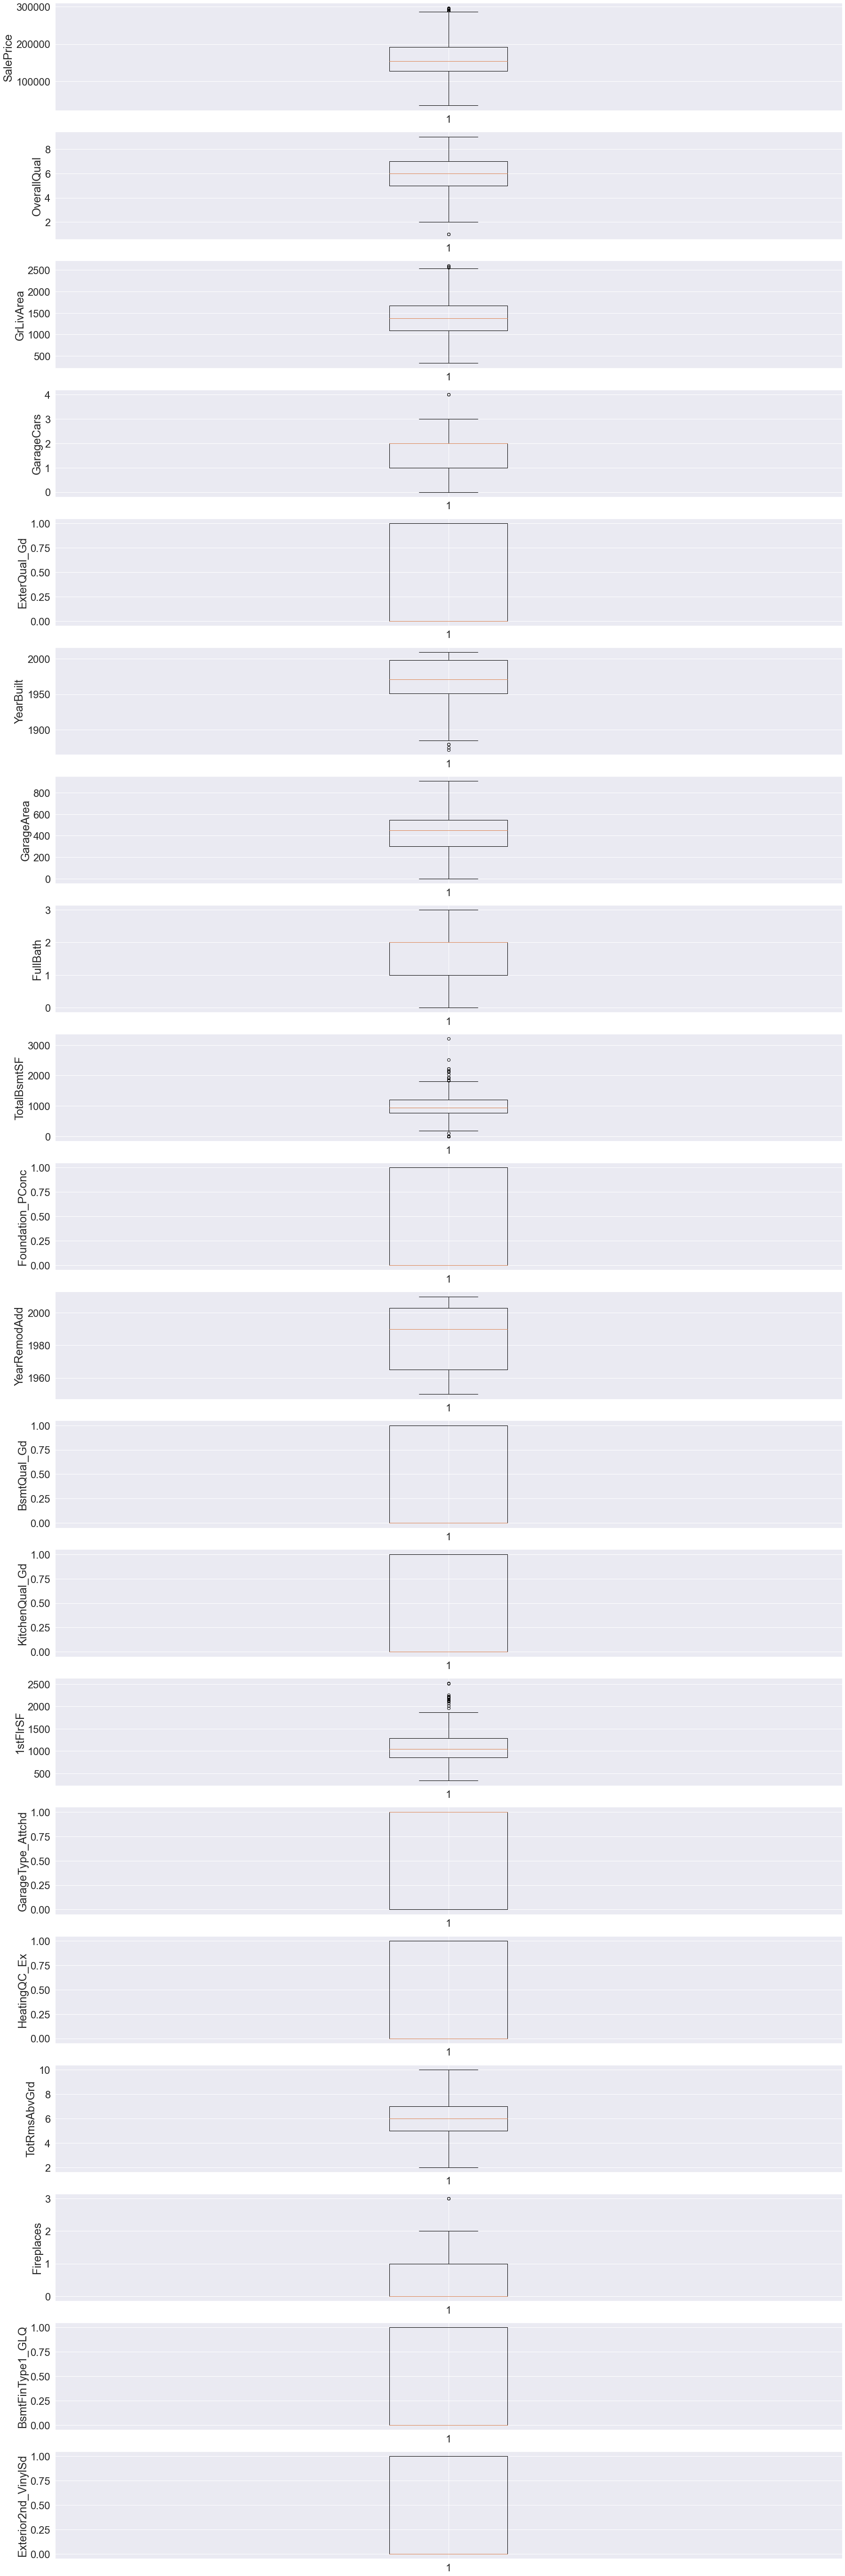

In [148]:
fig_1, axs_1 = plt.subplots(nrows = len(corrmat.nlargest(k, 'SalePrice').index)  , ncols= 1 ,figsize=(30,100))
for ctn, i in enumerate(corrmat.nlargest(k, 'SalePrice').index):
    axs_1[ctn].boxplot(data_train[i])
    axs_1[ctn].set_ylabel(i)

plt.show()

# Подготавливаем данные для обучения

In [149]:
len(list(data_train[corrmat.nlargest(k, 'SalePrice').index].columns))

20

In [150]:
data_for_fit = data_train[corrmat.nlargest(20, 'SalePrice').index]

In [151]:
# Отделяем значения для обучения модели
test_size = 0.3
train_size = 0.7
random_state = 42

train, test= train_test_split(data_for_fit, 
                              test_size = test_size, 
                              train_size = train_size,
                              random_state = random_state)   
train_X = train.drop('SalePrice', axis = 1)
train_Y = train['SalePrice']
test_X = test.drop('SalePrice', axis = 1)
test_Y = test['SalePrice']

In [152]:
train_X = tf.convert_to_tensor(train_X)

In [153]:
train_X

<tf.Tensor: shape=(863, 19), dtype=int64, numpy=
array([[   6, 1262,    2, ...,    0,    1,    1],
       [   6, 1068,    1, ...,    0,    1,    0],
       [   7, 1786,    2, ...,    1,    1,    1],
       ...,
       [   6, 1114,    2, ...,    0,    1,    1],
       [   8, 1360,    2, ...,    1,    1,    0],
       [   6, 1334,    2, ...,    1,    0,    0]], dtype=int64)>

In [154]:
train_Y = tf.convert_to_tensor(train_Y)

In [155]:
test_X = tf.convert_to_tensor(test_X)

In [156]:
test_Y = tf.convert_to_tensor(test_Y)

## Классификация с использованием классического перцептрона 

In [181]:
# # Parameters 
# batch_size = 20 
# display_step = 1
# adam = tf.keras.optimizers.Adam(learning_rate=0.000001)
# epochs = 300
# activation = 'ReLU'
# loss=tf.keras.losses.MeanAbsolutePercentageError()
# # loss = tf.losses.MeanAbsoluteError()

# # Создаем слой нормализации входных данных
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(train_X))
# print('Значения для нормализации: ', normalizer.mean.numpy())
# print('-------------------------------------------------------')

# input_regr_model = tf.keras.layers.Input(shape=(k,),
#                              name="Input_RegModel")
# # x = normalizer()(input_regr_model)
# X_shortcut = x
# x = tf.keras.layers.Dense(32, activation=activation)(input_regr_model)
# x = tf.keras.layers.Dense(64, activation=activation)(x)
# x = tf.keras.layers.Add()([x, X_shortcut])# SKIP Connection
# x = tf.keras.layers.Dense(128, activation=activation)(x)

# RegModel = tf.keras.Model(input_regr_model, x, name="encoder")
# plot_model(RegModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [202]:
# Parameters 
batch_size = 20 
display_step = 1
adam = tf.keras.optimizers.Adam(learning_rate=0.000001)
epochs = 3000
activation = 'ReLU'
loss=tf.keras.losses.MeanAbsolutePercentageError()
# loss = tf.keras.activations.selu
dropout = 0.45
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
# Создаем слой нормализации входных данных
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_X))
print('Значения для нормализации: ', normalizer.mean.numpy())


model = tf.keras.models.Sequential()
model.add(normalizer)
model.add(tf.keras.Input(shape=(k,)))
model.add(tf.keras.layers.Dense(32, activation=activation))
model.add(tf.keras.layers.Dense(64, activation=activation))
model.add(tf.keras.layers.Dense(128, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(256, activation=activation))
model.add(tf.keras.layers.Dense(512, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(1024, activation=activation))
model.add(tf.keras.layers.Dense(2048, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(512, activation=activation))
model.add(tf.keras.layers.Dense(256, activation=activation))
model.add(tf.keras.layers.Dense(128, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(64, activation=activation))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.summary()
model.compile(optimizer = adam, loss=loss)
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Значения для нормализации:  [[5.8748546e+00 1.4096382e+03 1.6280416e+00 3.0822703e-01 1.9692142e+03
  4.3152835e+02 1.5005794e+00 9.9063025e+02 4.0324447e-01 1.9832419e+03
  4.2873695e-01 3.9165697e-01 1.0960845e+03 5.6431043e-01 4.8088068e-01
  6.2479720e+00 5.1100808e-01 2.4449596e-01 3.2792577e-01]]
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliza  (None, 19)               39        
 tion)                                                           
                                                                 
 input_15 (InputLayer)       multiple                  0         
                                                                 
 dense_190 (Dense)           (None, 32)                640       
                                                                 
 dense_191 (Dense)           (None, 64)                2112      
             

In [203]:
model_fit = model.fit(x = train_X,
                      y = train_Y,
                      epochs=epochs,
                      batch_size = batch_size,
                      validation_data = (test_X, test_Y),
                      callbacks=[tb_callback])

Epoch 1/3000
44/44 [==============================] - 1s 14ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/3000
44/44 [==============================] - 0s 8ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 3/3000
44/44 [==============================] - 0s 8ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 4/3000
44/44 [==============================] - 0s 8ms/step - loss: 99.9999 - val_loss: 100.0000
Epoch 5/3000
44/44 [==============================] - 0s 8ms/step - loss: 99.9999 - val_loss: 99.9999
Epoch 6/3000
44/44 [==============================] - 0s 8ms/step - loss: 99.9999 - val_loss: 99.9999
Epoch 7/3000
44/44 [==============================] - 0s 8ms/step - loss: 99.9999 - val_loss: 99.9999
Epoch 8/3000
44/44 [==============================] - 0s 8ms/step - loss: 99.9999 - val_loss: 99.9999
Epoch 9/3000
44/44 [==============================] - 0s 8ms/step - loss: 99.9998 - val_loss: 99.9999
Epoch 10/3000
44/44 [==============================] - 0s 9ms/step - loss:

44/44 [==============================] - 0s 9ms/step - loss: 99.2073 - val_loss: 99.3021
Epoch 81/3000
44/44 [==============================] - 0s 9ms/step - loss: 99.1320 - val_loss: 99.2348
Epoch 82/3000
44/44 [==============================] - 0s 9ms/step - loss: 99.0656 - val_loss: 99.1607
Epoch 83/3000
44/44 [==============================] - 0s 9ms/step - loss: 98.9639 - val_loss: 99.0815
Epoch 84/3000
44/44 [==============================] - 0s 9ms/step - loss: 98.8663 - val_loss: 98.9952
Epoch 85/3000
44/44 [==============================] - 0s 9ms/step - loss: 98.7725 - val_loss: 98.9015
Epoch 86/3000
44/44 [==============================] - 0s 9ms/step - loss: 98.6578 - val_loss: 98.8005
Epoch 87/3000
44/44 [==============================] - 0s 9ms/step - loss: 98.5339 - val_loss: 98.6915
Epoch 88/3000
44/44 [==============================] - 0s 9ms/step - loss: 98.4138 - val_loss: 98.5749
Epoch 89/3000
44/44 [==============================] - 0s 9ms/step - loss: 98.2568 - va

44/44 [==============================] - 0s 8ms/step - loss: 41.6052 - val_loss: 41.7781
Epoch 160/3000
44/44 [==============================] - 0s 8ms/step - loss: 40.7931 - val_loss: 41.1627
Epoch 161/3000
44/44 [==============================] - 0s 8ms/step - loss: 40.6257 - val_loss: 40.7397
Epoch 162/3000
44/44 [==============================] - 0s 8ms/step - loss: 39.3061 - val_loss: 40.3158
Epoch 163/3000
44/44 [==============================] - 0s 8ms/step - loss: 39.3251 - val_loss: 39.8481
Epoch 164/3000
44/44 [==============================] - 0s 8ms/step - loss: 38.5553 - val_loss: 39.3372
Epoch 165/3000
44/44 [==============================] - 0s 8ms/step - loss: 39.2189 - val_loss: 38.9136
Epoch 166/3000
44/44 [==============================] - 0s 8ms/step - loss: 39.6698 - val_loss: 38.4769
Epoch 167/3000
44/44 [==============================] - 0s 9ms/step - loss: 39.1211 - val_loss: 38.1755
Epoch 168/3000
44/44 [==============================] - 0s 9ms/step - loss: 38.

Epoch 238/3000
44/44 [==============================] - 0s 9ms/step - loss: 33.4191 - val_loss: 30.2379
Epoch 239/3000
44/44 [==============================] - 0s 9ms/step - loss: 32.3570 - val_loss: 30.1150
Epoch 240/3000
44/44 [==============================] - 0s 9ms/step - loss: 33.7081 - val_loss: 30.0184
Epoch 241/3000
44/44 [==============================] - 0s 9ms/step - loss: 34.3445 - val_loss: 30.0169
Epoch 242/3000
44/44 [==============================] - 0s 9ms/step - loss: 33.1948 - val_loss: 29.9054
Epoch 243/3000
44/44 [==============================] - 0s 9ms/step - loss: 33.0221 - val_loss: 29.8346
Epoch 244/3000
44/44 [==============================] - 0s 9ms/step - loss: 32.4596 - val_loss: 29.6717
Epoch 245/3000
44/44 [==============================] - 0s 9ms/step - loss: 32.9988 - val_loss: 29.6542
Epoch 246/3000
44/44 [==============================] - 0s 9ms/step - loss: 31.9111 - val_loss: 29.5861
Epoch 247/3000
44/44 [==============================] - 0s 9ms/s

Epoch 317/3000
44/44 [==============================] - 0s 9ms/step - loss: 29.6906 - val_loss: 26.2560
Epoch 318/3000
44/44 [==============================] - 0s 9ms/step - loss: 29.9072 - val_loss: 26.1507
Epoch 319/3000
44/44 [==============================] - 0s 9ms/step - loss: 29.2795 - val_loss: 26.0013
Epoch 320/3000
44/44 [==============================] - 0s 9ms/step - loss: 30.5268 - val_loss: 26.0975
Epoch 321/3000
44/44 [==============================] - 0s 9ms/step - loss: 29.8075 - val_loss: 26.0939
Epoch 322/3000
44/44 [==============================] - 0s 9ms/step - loss: 30.0531 - val_loss: 26.1181
Epoch 323/3000
44/44 [==============================] - 0s 9ms/step - loss: 30.0799 - val_loss: 26.1435
Epoch 324/3000
44/44 [==============================] - 0s 9ms/step - loss: 31.3616 - val_loss: 26.2389
Epoch 325/3000
44/44 [==============================] - 0s 9ms/step - loss: 30.3510 - val_loss: 26.2307
Epoch 326/3000
44/44 [==============================] - 0s 9ms/s

Epoch 396/3000
44/44 [==============================] - 0s 9ms/step - loss: 28.1749 - val_loss: 24.3871
Epoch 397/3000
44/44 [==============================] - 0s 8ms/step - loss: 28.1035 - val_loss: 24.3579
Epoch 398/3000
44/44 [==============================] - 0s 9ms/step - loss: 28.2832 - val_loss: 24.2808
Epoch 399/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.7132 - val_loss: 24.2999
Epoch 400/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.4779 - val_loss: 24.3379
Epoch 401/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.9872 - val_loss: 24.2766
Epoch 402/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.4065 - val_loss: 24.1957
Epoch 403/3000
44/44 [==============================] - 0s 9ms/step - loss: 28.8448 - val_loss: 24.1851
Epoch 404/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.3504 - val_loss: 24.1225
Epoch 405/3000
44/44 [==============================] - 0s 9ms/s

Epoch 475/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.1913 - val_loss: 22.9251
Epoch 476/3000
44/44 [==============================] - 0s 9ms/step - loss: 26.4620 - val_loss: 22.8663
Epoch 477/3000
44/44 [==============================] - 0s 9ms/step - loss: 26.4402 - val_loss: 22.8179
Epoch 478/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.3196 - val_loss: 22.7207
Epoch 479/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.4815 - val_loss: 22.8123
Epoch 480/3000
44/44 [==============================] - 0s 9ms/step - loss: 26.9338 - val_loss: 22.7493
Epoch 481/3000
44/44 [==============================] - 0s 9ms/step - loss: 27.1175 - val_loss: 22.7934
Epoch 482/3000
44/44 [==============================] - 0s 9ms/step - loss: 26.5542 - val_loss: 22.6942
Epoch 483/3000
44/44 [==============================] - 0s 9ms/step - loss: 26.6923 - val_loss: 22.6796
Epoch 484/3000
44/44 [==============================] - 0s 9ms/s

Epoch 554/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.6138 - val_loss: 22.0338
Epoch 555/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.8164 - val_loss: 22.1450
Epoch 556/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.6109 - val_loss: 22.2407
Epoch 557/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.7910 - val_loss: 22.2649
Epoch 558/3000
44/44 [==============================] - 0s 8ms/step - loss: 24.8275 - val_loss: 22.1139
Epoch 559/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.5974 - val_loss: 22.0569
Epoch 560/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.8826 - val_loss: 22.0753
Epoch 561/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.4067 - val_loss: 21.9905
Epoch 562/3000
44/44 [==============================] - 0s 8ms/step - loss: 25.6757 - val_loss: 21.9433
Epoch 563/3000
44/44 [==============================] - 0s 9ms/s

Epoch 633/3000
44/44 [==============================] - 0s 9ms/step - loss: 25.5812 - val_loss: 21.4190
Epoch 634/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.3125 - val_loss: 21.3455
Epoch 635/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.5341 - val_loss: 21.3199
Epoch 636/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.0606 - val_loss: 21.3481
Epoch 637/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.8808 - val_loss: 21.2399
Epoch 638/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.3033 - val_loss: 21.0922
Epoch 639/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.1898 - val_loss: 20.9718
Epoch 640/3000
44/44 [==============================] - 0s 9ms/step - loss: 25.2188 - val_loss: 20.9988
Epoch 641/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.8302 - val_loss: 21.0661
Epoch 642/3000
44/44 [==============================] - 0s 9ms/s

44/44 [==============================] - 0s 9ms/step - loss: 24.4694 - val_loss: 20.6618
Epoch 712/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.3846 - val_loss: 20.4093
Epoch 713/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.5984 - val_loss: 20.4388
Epoch 714/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.8256 - val_loss: 20.4516
Epoch 715/3000
44/44 [==============================] - 0s 9ms/step - loss: 25.0597 - val_loss: 20.4249
Epoch 716/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.2517 - val_loss: 20.4206
Epoch 717/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.6640 - val_loss: 20.5271
Epoch 718/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.0773 - val_loss: 20.5465
Epoch 719/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.3611 - val_loss: 20.6333
Epoch 720/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.

Epoch 790/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.9183 - val_loss: 20.1557
Epoch 791/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.8483 - val_loss: 20.0021
Epoch 792/3000
44/44 [==============================] - 0s 9ms/step - loss: 24.2947 - val_loss: 20.0083
Epoch 793/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.6737 - val_loss: 20.0802
Epoch 794/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.5269 - val_loss: 19.9678
Epoch 795/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.2733 - val_loss: 19.9840
Epoch 796/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.2656 - val_loss: 20.0839
Epoch 797/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.4770 - val_loss: 20.0775
Epoch 798/3000
44/44 [==============================] - 0s 10ms/step - loss: 23.1793 - val_loss: 20.0719
Epoch 799/3000
44/44 [==============================] - 0s 9ms/

44/44 [==============================] - 0s 9ms/step - loss: 22.6546 - val_loss: 19.6876
Epoch 869/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.8118 - val_loss: 19.5680
Epoch 870/3000
44/44 [==============================] - 0s 9ms/step - loss: 23.1232 - val_loss: 19.7345
Epoch 871/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.6439 - val_loss: 19.8258
Epoch 872/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.4917 - val_loss: 19.7824
Epoch 873/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.5165 - val_loss: 19.9761
Epoch 874/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.2055 - val_loss: 19.9787
Epoch 875/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.7229 - val_loss: 19.8973
Epoch 876/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.8997 - val_loss: 19.9564
Epoch 877/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.

Epoch 947/3000
44/44 [==============================] - 0s 7ms/step - loss: 23.1044 - val_loss: 19.6713
Epoch 948/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.6324 - val_loss: 19.7135
Epoch 949/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.9541 - val_loss: 19.6449
Epoch 950/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.5714 - val_loss: 19.8485
Epoch 951/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.4556 - val_loss: 19.7970
Epoch 952/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.1159 - val_loss: 19.6833
Epoch 953/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.4880 - val_loss: 19.6080
Epoch 954/3000
44/44 [==============================] - 0s 8ms/step - loss: 23.3956 - val_loss: 19.6430
Epoch 955/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.6404 - val_loss: 19.5129
Epoch 956/3000
44/44 [==============================] - 0s 8ms/s

44/44 [==============================] - 0s 9ms/step - loss: 22.4994 - val_loss: 19.1572
Epoch 1026/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.7910 - val_loss: 19.0372
Epoch 1027/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.9534 - val_loss: 19.1261
Epoch 1028/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.4734 - val_loss: 19.0352
Epoch 1029/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.7583 - val_loss: 19.2569
Epoch 1030/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.0936 - val_loss: 19.3331
Epoch 1031/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.2366 - val_loss: 19.3279
Epoch 1032/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.6888 - val_loss: 19.4785
Epoch 1033/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.9755 - val_loss: 19.5051
Epoch 1034/3000
44/44 [==============================] - 0s 8ms/step - 

44/44 [==============================] - 0s 10ms/step - loss: 21.9110 - val_loss: 19.3060
Epoch 1104/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.6720 - val_loss: 19.5244
Epoch 1105/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.7480 - val_loss: 19.5193
Epoch 1106/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.7868 - val_loss: 19.4794
Epoch 1107/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.0420 - val_loss: 19.3958
Epoch 1108/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.1383 - val_loss: 19.2950
Epoch 1109/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.9990 - val_loss: 19.3407
Epoch 1110/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.9681 - val_loss: 19.4222
Epoch 1111/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.3151 - val_loss: 19.4401
Epoch 1112/3000
44/44 [==============================] - 0s 9ms/step -

44/44 [==============================] - 0s 8ms/step - loss: 21.5237 - val_loss: 19.2455
Epoch 1182/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.6166 - val_loss: 19.1706
Epoch 1183/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.1638 - val_loss: 19.1172
Epoch 1184/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.3515 - val_loss: 18.9495
Epoch 1185/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.8650 - val_loss: 18.8970
Epoch 1186/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.9951 - val_loss: 18.9171
Epoch 1187/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.6780 - val_loss: 18.7781
Epoch 1188/3000
44/44 [==============================] - 0s 9ms/step - loss: 21.2458 - val_loss: 18.7866
Epoch 1189/3000
44/44 [==============================] - 0s 9ms/step - loss: 22.2553 - val_loss: 18.9927
Epoch 1190/3000
44/44 [==============================] - 0s 9ms/step - 

44/44 [==============================] - 0s 8ms/step - loss: 21.4268 - val_loss: 19.0049
Epoch 1260/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.3724 - val_loss: 18.9245
Epoch 1261/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.6783 - val_loss: 19.0030
Epoch 1262/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.1994 - val_loss: 18.9795
Epoch 1263/3000
44/44 [==============================] - 0s 8ms/step - loss: 22.1723 - val_loss: 19.0326
Epoch 1264/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.4206 - val_loss: 19.2542
Epoch 1265/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.5935 - val_loss: 19.1469
Epoch 1266/3000
44/44 [==============================] - 0s 8ms/step - loss: 20.9700 - val_loss: 18.9927
Epoch 1267/3000
44/44 [==============================] - 0s 8ms/step - loss: 21.3119 - val_loss: 18.9801
Epoch 1268/3000
44/44 [==============================] - 0s 8ms/step - 

44/44 [==============================] - 0s 9ms/step - loss: 22.0323 - val_loss: 19.1193
Epoch 1338/3000
44/44 [==============================] - 0s 9ms/step - loss: 20.8118 - val_loss: 19.0517
Epoch 1339/3000
 1/44 [..............................] - ETA: 0s - loss: 21.1679

KeyboardInterrupt: 

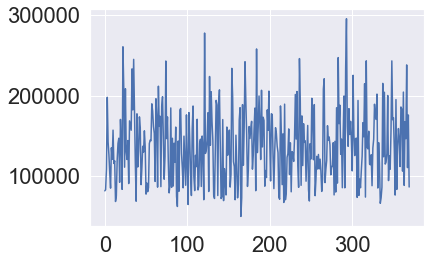

In [220]:
plt.plot(temp)

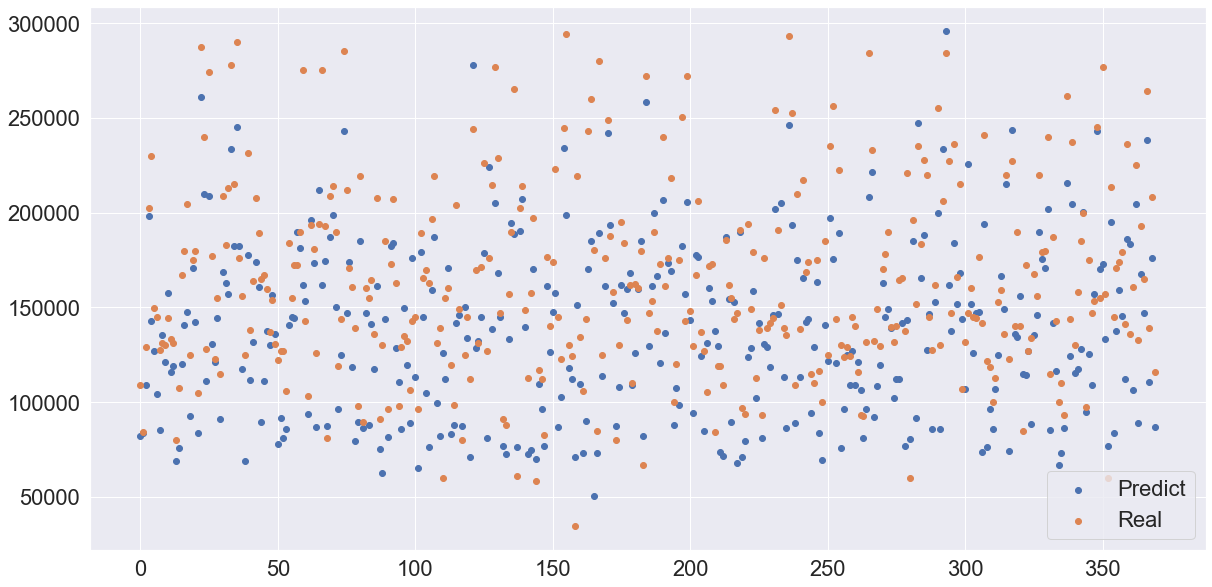

Mean squared error:  1436642731.3078043
Mean absolute error:  30268.208488175675
Coefficient of determination:  0.43139614462025677
Mean absolute percentage error:  19.034113962844877 %
Mean squared log error:  0.07495391860611238
Root Mean Squared Log Error:  0.27377713309572144


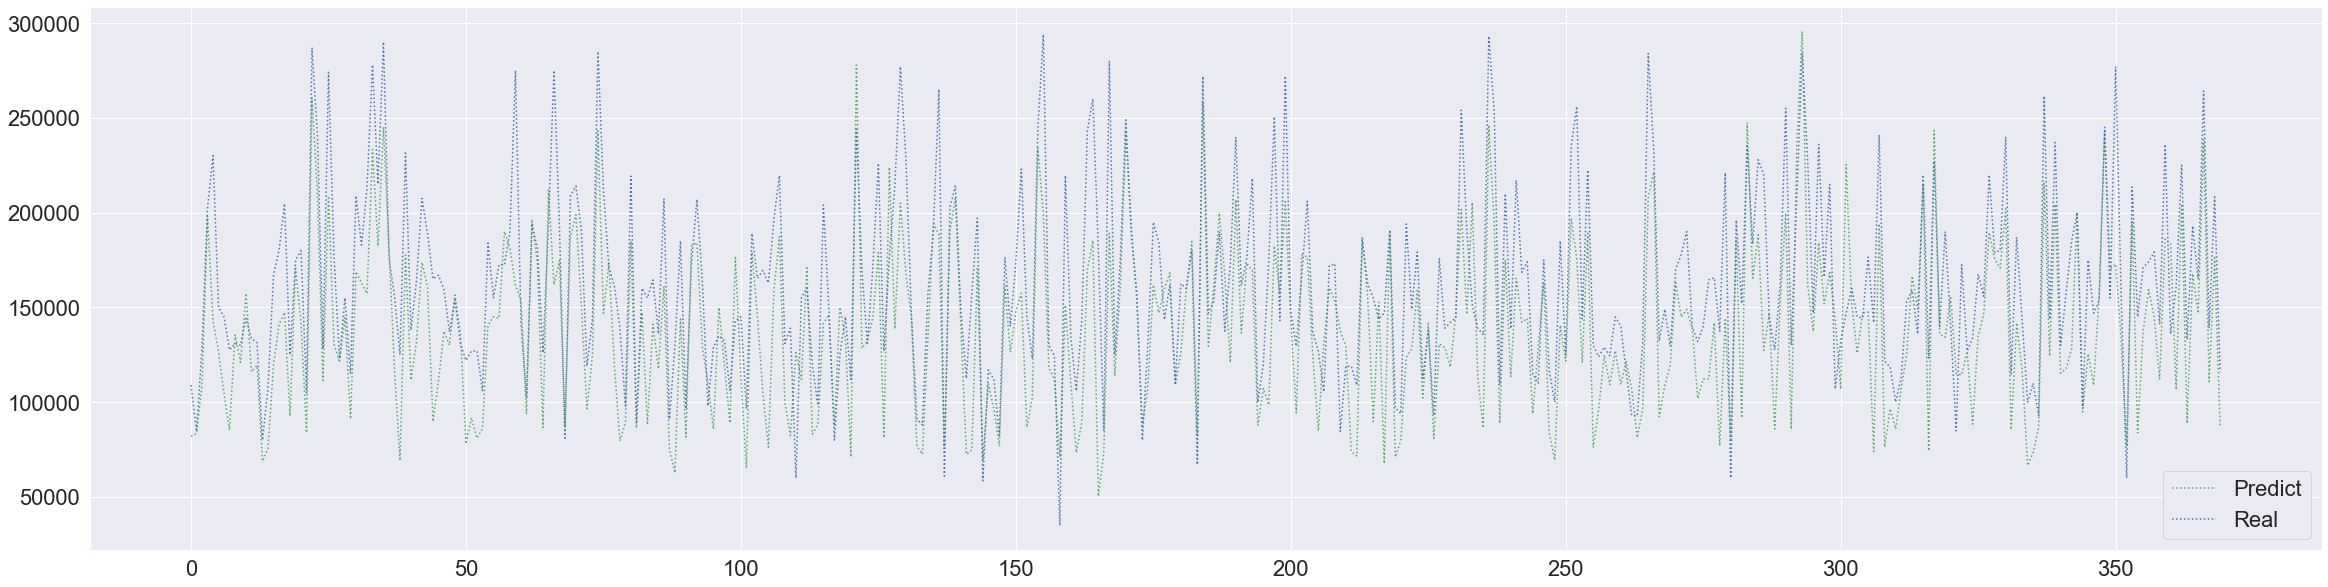

In [227]:
temp = []
for i in model(test_X).numpy().tolist():
    temp.append(i[0])
    
def PrintScatterAndCalculateLoos(test_X, test_Y):
    temp = test_X
    plt.figure(figsize=(20,10))
    plt.scatter(x = list(range(len(temp))), y = temp, label='Predict')
    plt.scatter(x = list(range(len(test_Y.numpy().tolist()))), y = test_Y.numpy().tolist(), label = 'Real')
    plt.legend(loc='lower right')
    plt.show()

    mse = mean_squared_error(test_Y.numpy().tolist(), temp)
    print('Mean squared error: ', mse)
    mae = mean_absolute_error(test_Y.numpy().tolist(), temp)
    print('Mean absolute error: ', mae)
    r2 = r2_score(test_Y.numpy().tolist(), temp)
    print('Coefficient of determination: ', r2)
    mape = mean_absolute_percentage_error(test_Y.numpy().tolist(), temp)
    print('Mean absolute percentage error: ', mape*100,'%')
    msle = mean_squared_log_error(test_Y.numpy().tolist(), temp)
    print('Mean squared log error: ', msle)
    rmsle = np.sqrt(msle)
    print('Root Mean Squared Log Error: ', rmsle)
    
    plt.figure(figsize=(40,10))
    plt.plot(temp,'g:', label = 'Predict')
    plt.plot(test_Y.numpy().tolist(), 'b:', label = 'Real')
    plt.legend(loc='lower right')
    plt.show()
    
    
       
PrintScatterAndCalculateLoos(temp, test_Y)

In [139]:
# test_Y.numpy().tolist()

## Предсказание цены с использованием леса рандомизированных деревьев

In [140]:
clfRFC = RandomForestClassifier(n_estimators = 500, 
                                criterion = 'gini', 
                                max_depth = 150, 
                                min_samples_split = 2, 
                                random_state=0)

In [141]:
clfRFC.fit(train_X, train_Y)

RandomForestClassifier(max_depth=150, n_estimators=500, random_state=0)

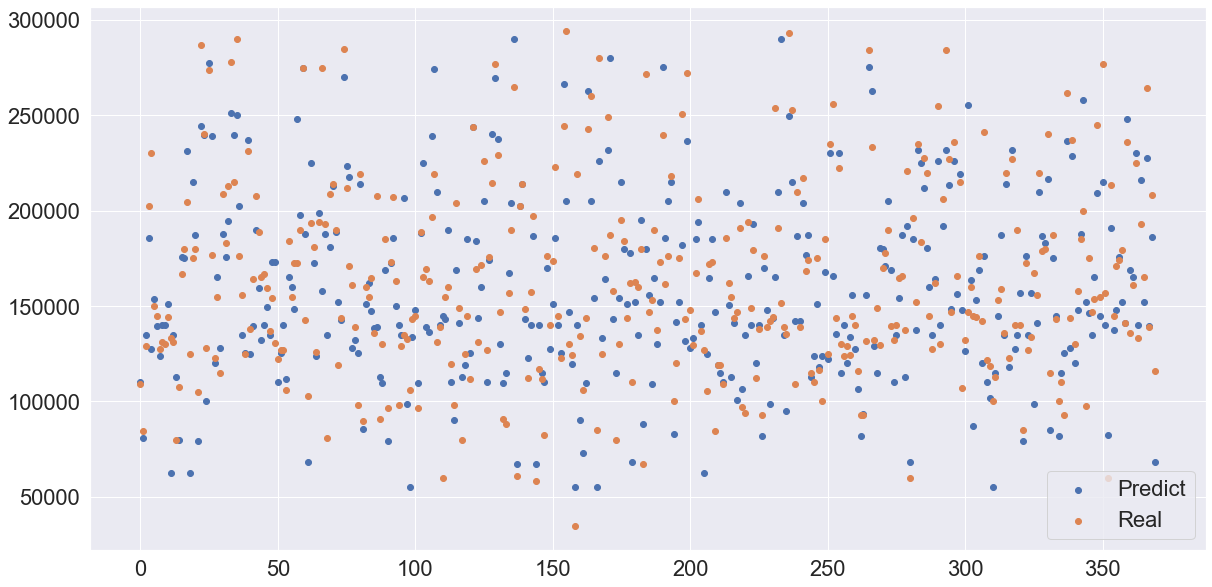

Mean squared error:  917016969.6135135
Mean absolute error:  21480.094594594593
Coefficient of determination:  0.637057026769464
Mean absolute percentage error:  14.290877293833182 %
Mean squared log error:  0.04220481652830454
Root Mean Squared Log Error:  0.20543810875371818


In [142]:
PrintScatterAndCalculateLoos(clfRFC.predict(test_X), test_Y)

## Предсказание цены с использованием определенных рандомизированных деревьев

In [143]:
clfDTC = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

In [144]:
clfDTC.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=0)

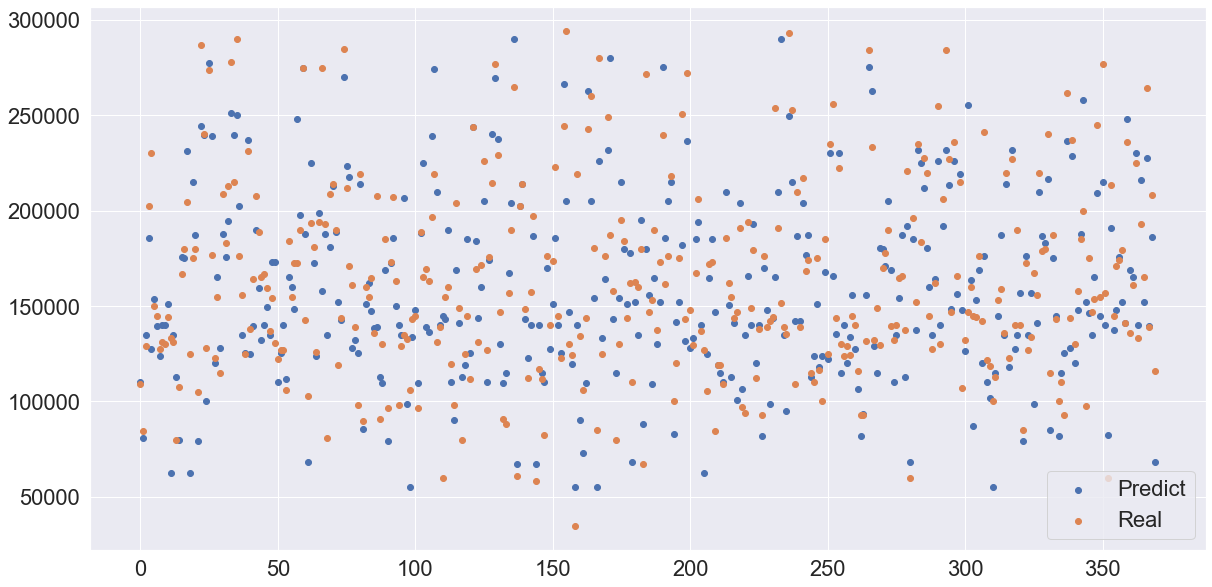

Mean squared error:  917016969.6135135
Mean absolute error:  21480.094594594593
Coefficient of determination:  0.637057026769464
Mean absolute percentage error:  14.290877293833182 %
Mean squared log error:  0.04220481652830454
Root Mean Squared Log Error:  0.20543810875371818


In [146]:
PrintScatterAndCalculateLoos(clfRFC.predict(test_X), test_Y)